In [1]:
%matplotlib inline
#%matplotlib notebook
from universal import *

from scipy.optimize import minimize
from scipy.misc import derivative
from scipy.interpolate import interp2d
from scipy import signal
import cPickle as pickle

In [2]:
def plot_config():
    from cycler import cycler
    from matplotlib.ticker import AutoMinorLocator

    fsize = 14 # a quarter of the paper width: 20 pt; half of the paper width: 12
    font = {'size' : fsize, 'family' : 'serif'}
    color_cycle = ['r', 'b', 'g', 'c', 'm', 'y', 'k']
    linestyle_cycle = ['-', '--', '-.', ':', (0, (5, 2, 5, 2)), (0, (10, 2, 5, 2, 2, 2)), (0, (12, 2, 2, 2))]
    marker_cycle = ['o', 'd', 'v', '^', '<', '>', '*']
    
    mpl.rc('font', **font)
    mpl.rc('xtick', labelsize = 10, direction = 'in', top   = True)
    mpl.rc('ytick', labelsize = 10, direction = 'in', right = True)
    mpl.rc('xtick.major', size = 5, width = 1)
    mpl.rc('ytick.major', size = 5, width = 1)
    mpl.rc('xtick.minor', size = 3, width = 0.7, visible = True)
    mpl.rc('ytick.minor', size = 3, width = 0.7, visible = True)
    
    mpl.rc('lines', linewidth=2, markersize=6, color='r')
    # mpl.rc('lines', linestyle = 'solid')
    mpl.rc('axes', labelpad = 0, prop_cycle=(cycler('color', color_cycle) + cycler('linestyle', linestyle_cycle) + cycler('marker', marker_cycle)))
    mpl.rc('legend', fontsize = 12, labelspacing = 0.05, handletextpad=0.4, frameon=False, handlelength=2.1)
    
    mpl.rc('figure', dpi = 100, figsize = (4, 4))
    mpl.rc('figure.subplot', bottom = 0.15, top = 0.9, left = 0.15, right = 0.9)
    
    mpl.rc('image', cmap = 'jet')
    
    return
plot_config()

rootdir = r'\\afs\ifh.de\group\pitz\data\lixiangk\work'
simdir = r'\\afs\ifh.de\group\pitz\data\lixiangk\sim'

In [3]:
dt = 10e-12
dz = g_c*dt; print 'Light travelled: ', dz*1e3
EG = 30*dz
gg = kinetic2gamma(EG); print 'Gamma: ', gg
bb = gamma2beta(gg); print 'Beta: ', bb/2
dz = bb*g_c*dt
print 'Excursion: ', dz*1e3

Light travelled:  2.99792458
Gamma:  1.17600376299
Beta:  0.26311892769329304
Excursion:  1.577621401589932


## Radial space charge calculated by analytical formula

In [143]:
rho_z = lambda z, sigma_z: 1./np.sqrt(2.*np.pi)/sigma_z*np.exp(-z**2/2./sigma_z**2)
rho_r = lambda r, sigma_r: 1./(2.*np.pi)/sigma_r**2*np.exp(-r**2/2./sigma_r**2)

fEr = lambda r, z, sigma_r, sigma_z, gamma, Qtot:\
       Qtot*rho_z(z*gamma, sigma_z*gamma)/(2.*np.pi*r*g_eps0)*(1.-np.exp(-r**2/2./sigma_r**2))*gamma

Text(0,0.5,'$E_r(z)$ (V/m)')

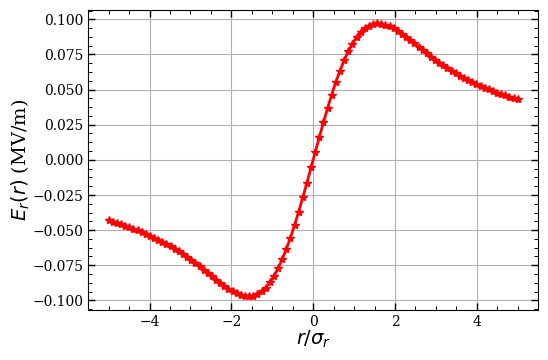

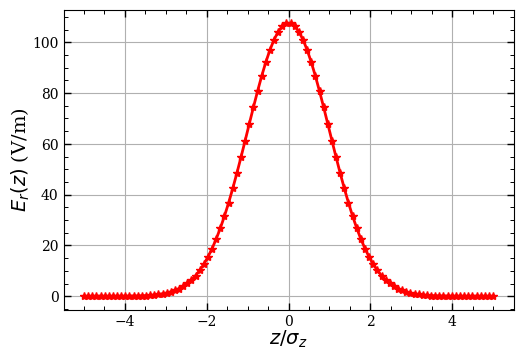

In [145]:
Qtot = 30e-12; sigma_r = 1.0e-3; sigma_z = 1.0e-3
gamma = 1. #+16./g_mec2

rr = np.linspace(-5*sigma_r, 5*sigma_r, 100)
Er_r = fEr(rr, 0, sigma_r, sigma_z, gamma, Qtot)/gamma**2
zz = np.linspace(-5*sigma_z, 5*sigma_z, 100)
Er_z = fEr(1e-6, zz, sigma_r, sigma_z, gamma, Qtot)/gamma**2

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(rr/sigma_r, Er_r/1e6, '-*')
ax.grid()
ax.set_xlabel(r'$r/\sigma_r$')
ax.set_ylabel(r'$E_r(r)$ (MV/m)')

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(zz/sigma_z, Er_z, '-*')
ax.grid()
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$E_r(z)$ (V/m)')

## Space charge in 3D coordinate system

In [5]:
from tracking import *

In [ ]:
Qtot = 3e9*g_qe; sigma_x = 70e-6; sigma_y = 7.5e-6; sigma_z = 7.0e-3; gamma = 1.+1300./g_mec2
sc = SpaceCharge3D(Qtot, sigma_x, sigma_y, sigma_z, gamma)
yy = 1.0*sigma_y
print sc.fEy(0, 10e-6, 0), sc.fEy1(0, 10e-6, 0)
#print sc.fEx(v, 0, 0)

## Space charge in $R-Z$ coordinate system

In [80]:
from tracking import *

In [81]:
Qtot = 30e-12; sigma_r = 1e-3; sigma_z = 1e-3; gamma = 1. #+150./g_mec2; print gamma
nr = 16; nz = 16; dr = 5*sigma_r/nr; dz = 5*sigma_z/nz

import timeit
#sc3d = SpaceCharge3D(Qtot, sigma_r, sigma_r, sigma_z, gamma)
scrz = SpaceChargeRZ(Qtot, sigma_r, sigma_z, nr, nz, gamma)
# time1 = timeit.default_timer()
scrz.build()
# time2 = timeit.default_timer()
# print time2-time1

# rr = np.arange(0, 5*sigma_r, dr)+dr/2.
# zz = np.arange(-5*sigma_z, 5*sigma_z, dz)+dz/2.
r0, z0 = dr/2., dz/2.
print r0, z0

time1 = timeit.default_timer()
phi = scrz.phi_static_RZ(r0*7, z0)
time2 = timeit.default_timer()
print time2-time1, ': ', phi

time1 = timeit.default_timer()
phi = scrz.phi_static(r0, z0)
time2 = timeit.default_timer()
print time2-time1, ': ', phi

# time1 = timeit.default_timer()
# phi = scrz.phi_static_RZ(r0, z0)
# time2 = timeit.default_timer()
# print time2-time1, ': ', phi

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
0.00015625 0.00015625
0.0290394000003 :  187.15750604015918
853.668245178953
0.00977369999964 :  214.36798609137747


[ 12263.20901055  13168.33553977  15191.03941735  17702.88606817
  20846.40475884  24781.10182317  29641.28713733  35444.66811064
  41944.04050869  48451.04982269  53718.92476587  56016.73809357
  53503.24327218  44874.77948676  30059.87075943  10596.85618021
 -10596.85618021 -30059.87075943 -44874.77948677 -53503.24327218
 -56016.73809357 -53718.92476587 -48451.04982269 -41944.04050869
 -35444.66811064 -29641.28713733 -24781.10182317 -20846.40475884
 -17702.88606817 -15191.03941735 -13168.33553977 -12263.20901055]


Text(0,0.5,'$E_z(z)$ (MV/m)')

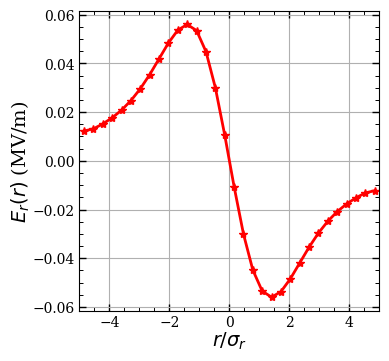

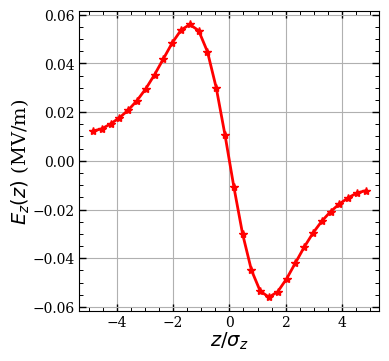

In [82]:
rr = np.arange(-5*sigma_r, 5*sigma_r, dr)+dr/2.
zz = np.arange(-5*sigma_z, 5*sigma_z, dz)+dz/2.

R, Z = np.meshgrid(rr, zz)
Er = np.array([scrz.EM3D(r, 0, 0)[0]-scrz.EM3D(r, 0, 0)[4] for r in rr]); print Er
Ez = np.array([scrz.EM3D(0, 0, z)[2] for z in zz])
#np.savetxt('static_RZ_64x16.dat', np.array([rr, Er]).T, fmt='%12.4E')

def fEr(r, sigma_r, Qtot):
    if abs(r) < sigma_r:
        return Qtot/4./np.pi/g_eps0*r/sigma_r**3
    else:
        return Qtot/4./np.pi/g_eps0*r/r**2/abs(r)
#Er_0 = np.array([-fEr(rp, sigma_r, Qtot) for rp in rr])

fig, ax = plt.subplots()
ax.plot(rr/sigma_r, Er/1e6, '-*')
ax.set_xlim(-5, 5)
#ax.set_ylim(0, 100000)
#ax.plot(rr*1e6, Er_0, '-*')
phi = np.array([scrz.phi_2d(r, 0)[0] for r in rr])
#ax.plot(rr*1e3, phi*1e5, '-*')
#ax.plot(rr*1e6, np.gradient(phi, 5.*sigma_r/nr), '-*')
ax.grid()
ax.set_xlabel(r'$r/\sigma_r$')
ax.set_ylabel(r'$E_r(r)$ (MV/m)')

fig, ax = plt.subplots()
ax.plot(zz/sigma_z, Ez/1e6, '-*')
phi = np.array([scrz.phi_2d(0, z)[0] for z in zz])
#ax.plot(zz*1e3, phi*1e5, '-')
#ax.plot(zz*1e6, np.gradient(phi, 5.*sigma_z/nz), '-*')
ax.grid()
ax.set_xlabel(r'$z/\sigma_z$')
ax.set_ylabel(r'$E_z(z)$ (MV/m)')

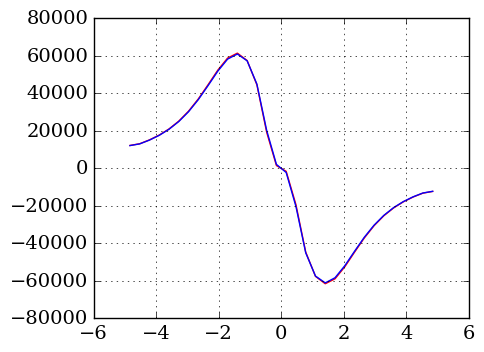

In [121]:
data = np.loadtxt('static_RZ.dat')
#plt.plot(data[:,0]*1e3, data[:,1], '-')
data = np.loadtxt('static_RZ3.dat')
plt.plot(data[:,0]*1e3, data[:,1], '-')
data = np.loadtxt('static_RZ4.dat')
plt.plot(data[:,0]*1e3, data[:,1], '-')
plt.grid()
#plt.xlim(0,5)
plt.show()

In [3]:
### generate 3D distribution
sigma_r = 1.0e-6; sigma_z = 1.0e-6; nr = 32; nz = 64

mean = [0, 0, 0]
cov = [[sigma_r**2, 0, 0], [0, sigma_r**2, 0], [0, 0, sigma_z**2]]
x, y, z = np.random.multivariate_normal(mean, cov, 100000).T

dr = 5*sigma_r/nr; dz = 5*sigma_z/nz
rr = np.linspace(0, 5*sigma_r, nr)
zz = np.linspace(-5*sigma_r, 5*sigma_r, 2*nz+1)

global rho;
rho = np.zeros((nr, nz*2+1))

for i in np.arange(len(x)):
    ir = int(np.sqrt(x[i]**2+y[i]**2)/dr+0.)
    if z[i]>=0:
        iz = nz+int(z[i]/dz+0.5)
    else:
        iz = nz-int(-z[i]/dz+0.5)
    if ir>=0 and ir<nr and iz>=0 and iz < nz*2+1:
        rho[ir, iz] += 1.
#print rho.sum(axis=0)
fig, ax = plt.subplots(figsize = (5, 5))
ax.plot(z*1e6, y*1e6, '.')
ax.grid()
ax.axis([-4, 4, -4, 4])

fig, ax = plt.subplots(figsize = (6, 4))
ax.plot(rr*1e6, rho.sum(axis=1), '-*'); ax.hist(np.sqrt(x**2+y**2)*1e6, bins=32)
#ax.plot(zz*1e6, rho[3,:], '-*'); #ax.hist(z*1e6, bins=32)
ax.grid()

In [54]:
Qtot = 1e-12; sigma_r = 1.0e-6; sigma_z = 1.0e-6

mean = [0, 0, 0]
cov = [[sigma_r**2, 0, 0], [0, sigma_r**2, 0], [0, 0, sigma_z**2]]

xb, yb, zb = np.random.multivariate_normal(mean, cov, 100000).T

### Comparison

The 3D method gives accurate solutions to the space charge forces, while the RZ method is only valid when gamma is small. The reason lies that when gamma is very large, the discrete charge rings are far from the point concerned and the coulomb force is under estimated, due to the inverse square law. The radial component can be easily calculated using the analytical formula, which is only valid for relativistic beam with a large aspect ratio.

In [55]:
nr = 40; nz = 200; gamma = 10.#+150./g_mec2; print gamma

sc3d = SpaceCharge3D(Qtot, sigma_r, sigma_r, sigma_z, gamma)
sc2d = SpaceChargeRZ(Qtot, sigma_r, sigma_z, nr, nz, gamma)
sc.get_rho_RZ(xb, yb, zb)

#rp, zp = sc.dr*(8+0.5), sc.dz*(20+0.5) ; print rp, zp
rp, zp = 1.0625e-6, 1.0625e-6
print sc3d.fEx(rp, 0, zp)/1e9, sc3d.fEz(rp, 0, zp)/1e9
print sc.fEr(rp, zp, 0)/1e9, sc.fEz(rp, zp, 0)/1e9
print sc.fEr(rp, zp, 1)/1e9, sc.fEz(rp, zp, 1)/1e9
print fEr(rp, zp, sigma_r, sigma_z, gamma, Qtot)/1e9

1.64781491978 0.0865035955797
[ 1.63097047] [ 0.09146845]
1.65547358533


### Calculation of space charge using 3D

In [106]:
Qtot = 3e9*g_qe; sigma_x = 70e-6; sigma_y = 7.5e-6; sigma_z = 7.0e-3; gamma = 1.+1300./g_mec2
sc = SpaceCharge3D(Qtot, sigma_x, sigma_y, sigma_z, gamma)
yy = -1.0*np.array([3, 2.5, 2, 1.5, 1.25, 1, 0.75, 0.5, 0.25])*sigma_y
Ey_y = np.array([])
Ey_y = np.zeros(len(yy))
for i, v in enumerate(yy):
    Ey_y[i] = sc.fEy(0, v, 0)
    print Ey_y[i],',',

KeyboardInterrupt: 

In [87]:
Qtot = 1e-12; sigma_r = 1.0e-6; sigma_z = 1.0e-6; gamma = 1.+150./g_mec2

sc = SpaceCharge3D(Qtot, sigma_r, sigma_r, sigma_z, gamma)
zz = -1.0*np.array([10, 9, 8, 7, 6, 5.5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1.25, 1, 0.75, 0.5, 0.25])*sigma_z
Ez_z = np.zeros(len(zz))
for i, v in enumerate(zz):
    Ez_z[i] = sc.fEz(0, 0, v)
    print Ez_z[i],',', 

In [71]:
Qtot = 1e-12; sigma_r = 1.0e-6; sigma_z = 1.0e-6; gamma = 1.+150./g_mec2
zz = -1.0*np.array([10, 9, 8, 7, 6, 5.5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1.25, 1, 0.75, 0.5, 0.25, 0])*sigma_z
Ez_z = np.array([-1068.71155235, -1329.53950284, -1701.24698937, -2259.18565239, -3159.65480883, -3839.9478985,\
                 -6258.93259551, -8938.47979824, -15170.6328943, -31536.0527241, -70891.8916114, -144539.35086,\
                 -235874.717597, -269004.384616, -278927.714006, -256341.826416, -197732.48045, -107937.469484, 0])

In [36]:
Qtot = 50e-12; sigma_r = 0.6e-6; sigma_z = 1.0e-6; gamma = 150./g_mec2+1; 
zz = -1.0*np.array([10, 9, 8, 7, 6, 5.5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1.25, 1, 0.75, 0.5, 0.25, 0])*sigma_z
Ez_z = np.array([-53435.5903638, -66476.9950999, -85062.3827171, -112959.342919, -157982.864754, -191997.588353,\
                 -313328.084992, -449759.290142, -774702.576927, -1647178.35564, -3776520.26685, -7798420.90377,\
                 -12821018.2989, -14658361.6471, -15227062.9301, -14012182.3256, -10818082.5589, -5908374.12811, 0])

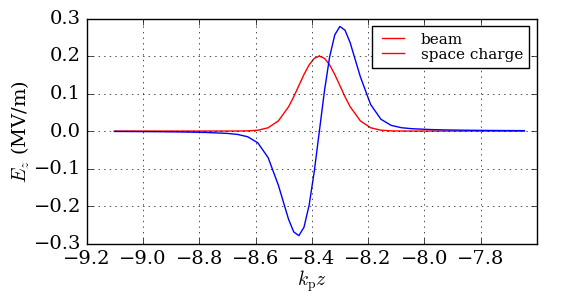

In [78]:
lpc = PlasmaChannel(ne = 1.5e23); lamp = lpc.wavelength(); kp = 2.*np.pi/lamp
beam_zc = -4-60e-6*kp

fig, ax = plt.subplots(figsize=(6,3))
ax.plot( zz*kp+beam_zc, gaussian( zz*kp+beam_zc, 1e-6*kp, beam_zc, 0.2), 'r-')
ax.plot(-zz*kp+beam_zc, gaussian(-zz*kp+beam_zc, 1e-6*kp, beam_zc, 0.2), 'r-')
ax.plot( zz*kp+beam_zc,  Ez_z/1e6, 'b-')
ax.plot(-zz*kp+beam_zc, -Ez_z/1e6, 'b-')
ax.grid()
ax.set_xlabel(r'$k_{\rm p}z$')
ax.set_ylabel(r'$E_z$ (MV/m)')
ax.legend([r'beam', r'space charge'])
#ax.set_xlim(-21, 0)
#fig.savefig('space-charge-50pC'+figtype)

In [86]:
Qtot = 1e-12; sigma_r = 1.0e-6; sigma_z = 1.0e-6; gamma = 1.+150./g_mec2
sc = SpaceCharge3D(Qtot, sigma_r, sigma_r, sigma_z, gamma)
xx = -1.0*np.array([10, 9, 8, 7, 6, 5.5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1.25, 1, 0.75, 0.5, 0.25])*sigma_r
# Ex_x = np.array(-59707075934.7, -66350871987.8, -74654763320.6, -85330177721.7, -99562821590.1, -108619429210.0,\
#                 -132764203145.0, -149321525576.0, -170343103058.0, -196962902383.0, -228515206451.0, -258341977376.0,\
#                 -161415282712.0, -155502256288.0, -141063532600.0, -117193111286.0, -84256877214.5, -44123794492.0)
Ex_x = np.zeros(len(xx))
for i, v in enumerate(xx):
    Ex_x[i] = sc.fEx(v, 0, 0)
    print Ex_x[i],',',

In [89]:
Qtot = 1e-12; sigma_r = 1.0e-6; sigma_z = 1.0e-6; gamma = 1.+150./g_mec2
xx = -1.0*np.array([10, 9, 8, 7, 6, 5.5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1.25, 1, 0.75, 0.5, 0.25, 0])*sigma_r
Ex_x = np.array([-715601723.284, -795391164.78, -895104740.916, -1023279988.76, -1194145916.5, -1302863999.23,\
                 -1592682854.87, -1791413837.0, -2043717741.79, -2363202504.24, -2741879971.6, -3099854264.60,\
                 -3228305654.24, -3110045125.8, -2821321192.07, -2343859039.70, -1685042467.6, -882358273.419, 0])

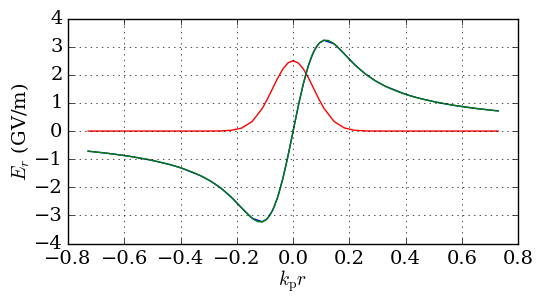

In [97]:
lpc = PlasmaChannel(ne = 1.5e23); lamp = lpc.wavelength(); kp = 2.*np.pi/lamp

fig, ax = plt.subplots(figsize=(6,3))
ax.plot( xx*kp, gaussian( xx*kp, 1e-6*kp, 0, 2.5), 'r-')
ax.plot(-xx*kp, gaussian(-xx*kp, 1e-6*kp, 0, 2.5), 'r-')
ax.plot( xx*kp,  Ex_x/1e9, 'b-')
ax.plot(-xx*kp, -Ex_x/1e9, 'b-')
rr = np.linspace(-10, 10, 100)*sigma_r
Er_r = fEr(rr, 0, sigma_r, sigma_z, gamma, Qtot)
ax.plot(rr*kp, Er_r/1e9, 'g-')
ax.grid()
ax.set_xlabel(r'$k_{\rm p}r$')
ax.set_ylabel(r'$E_r$ (GV/m)')
#ax.legend([r'beam', r'space charge'])
#ax.set_xlim(-21, 0)
#fig.savefig('space-charge-50pC'+figtype)

In [27]:
zz = -1.0*np.array([10, 9, 8, 7, 6, 5.5, 4.5, 4, 3.5, 3, 2.5, 2, 1.5, 1.25, 1, 0.75, 0.5, 0.25, 0])*sigma_z
Ex_z = np.array([62057.3771687, 86475.3616713, 125951.804807, 194666.540523, 327772.661093, 446178.515856,\
                2299467.77799, 12623656.7501, 74092275.857, 364422133.978, 1421697980.49, 4345913764.51,\
                10375473897.8, 14606829181.1, 19325039251.5, 24026155099.5, 28069625683.3, 30815593716.5,\
                31789393945.8])
np.savetxt('beam-loading/space-charge.dat', np.array([zz, Ez_z, Ex_z]).T, fmt = '%12.6E')
#xx = np.linspace(-10*sigma_r, 10*sigma_r, 20)
#Ex_z = np.zeros(len(zz))
for i, v in enumerate(zz):
    #Ex_z[i] = SC_Ex(45e-6/4., 0, v, sigma_r, sigma_z, gamma)
    print Ex_z[i], 

62057.3771687 86475.3616713 125951.804807 194666.540523 327772.661093 446178.515856 2299467.77799 12623656.7501 74092275.857 364422133.978 1421697980.49 4345913764.51 10375473897.8 14606829181.1 19325039251.5 24026155099.5 28069625683.3 30815593716.5 31789393945.8


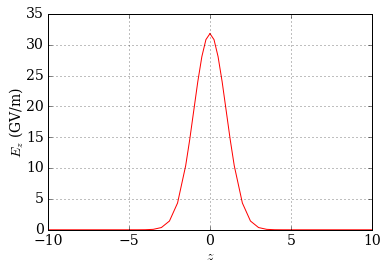

In [8]:
fig, ax = plt.subplots(figsize=(6,4))
ax.plot(zz/sigma_z, Ex_z/1e9, '-')
ax.plot(-zz/sigma_z, Ex_z/1e9, 'r-')
ax.grid()
ax.set_xlabel(r'$z$')
ax.set_ylabel(r'$E_x$ (GV/m)')

# Space charge 3D using FFT
## Step-by-step scripts

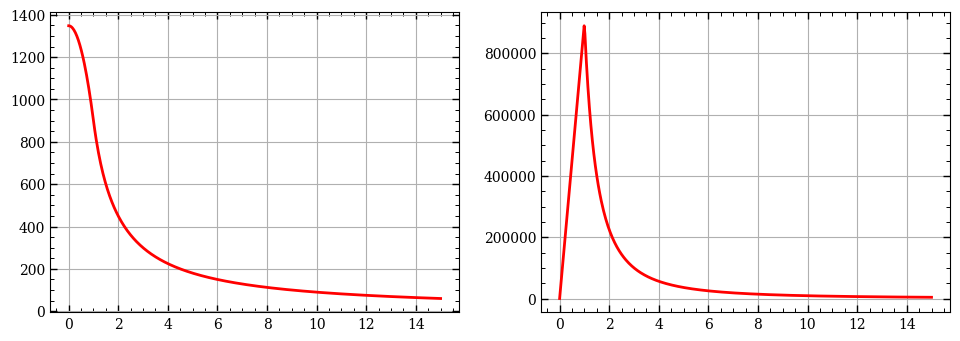

In [21]:
def static_potential(r, R, Q = 100e-12):
    cc = Q/4./np.pi/g_eps0
    if r<=R:
        phi = cc*((R**2-r**2)/2./R**3+1./R)
    else:
        phi = cc/r
    return phi
def electric_field(r, R, Q = 100e-12):
    cc = Q/4./np.pi/g_eps0
    if r<=R:
        Er = cc*r/R**3
    else:
        Er = cc/r**2
    return Er

R = 1e-3
r = np.linspace(0, 15*R, 501)
phi = np.array([static_potential(x, R) for x in r])
Er = np.array([electric_field(x, R) for x in r])

fig, [ax1, ax2] = plt.subplots(figsize = (12, 4), ncols = 2)
ax1.plot(r/R, phi, '-')
ax1.grid()
ax2.plot(r/R, Er, '-')
ax2.grid()

np.savetxt('R1mm.dat', np.array([r, phi, Er]).T, fmt = '%12.6E')

In [947]:
def GF3D((x, y, z)):
    '''
    Green function (GF) in 3D cartesian CS
    '''
    r = np.sqrt(x*x+y*y+z*z)
    return np.where(r>0, 1./np.sqrt(x*x+y*y+z*z), 1e100)
def IGF3D((x, y, z)):
    '''
    Indefinite integral of or integrated green function in 3D cartesian CS, according to Eq.(2) on 129901-2. 
    Here, `indefinite` refers to the integrating limits
    ''' 
    r = np.sqrt(x*x+y*y+z*z)
    
    #EPS = 1e-12
    #if abs(r) < EPS:
    #    return 0
    #if abs(x) < EPS:
    #    return y*z*np.log(r)
    #if abs(y) < EPS:
    #    return z*x*np.log(r)
    #if abs(z) < EPS:
    #    return x*y*np.log(r)
    
    x2 = x*x; y2 = y*y; z2 = z*z
    xy = x*y; yz = y*z; zx = z*x
    s = yz*np.log(x+r)+zx*np.log(y+r)+xy*np.log(z+r)
    a = -0.5*x2*np.arctan(yz/x/r)
    b = -0.5*y2*np.arctan(zx/y/r)
    c = -0.5*z2*np.arctan(xy/z/r)
    return s+a+b+c

def integral_IGF3D(xp, yp, zp, hx, hy, hz):
    '''
    Integral of green function in 3D cartesian CS
    Parameters
      xp: center of the volume in x direction
      yp: center of the volume in y direction
      zp: center of the volume in z direction
      hx: length of the volume in x direction
      hy: length of the volume in y direction
      hz: length of the volume in z direction
    Returns
      rr: integral over a volume defined by (xp, yp, zp, hx, hy, hz)
    '''
    xl, xu, yl, yu, zl, zu = xp-hx/2., xp+hx/2., yp-hy/2., yp+hy/2., zp-hz/2., zp+hz/2.
    rr = (IGF3D((xu, yu, zu))-IGF3D((xu,yl,zu))-IGF3D((xl,yu,zu))+IGF3D((xl,yl,zu)))-\
         (IGF3D((xu, yu, zl))-IGF3D((xu,yl,zl))-IGF3D((xl,yu,zl))+IGF3D((xl,yl,zl)))
    return rr
def transposed_IGF3D(x, y, z, xp, yp, zp, hx, hy, hz):
    '''
    Transposed finite integral of green function in 3D Cartesian CS
    Parameters
      xp: center of the volume in x direction
      yp: center of the volume in y direction
      zp: center of the volume in z direction
      hx: length of the volume in x direction
      hy: length of the volume in y direction
      hz: length of the volume in z direction
    '''
    xl, xu, yl, yu, zl, zu = x-xp+hx/2., x-xp-hx/2., y-yp+hy/2., y-yp-hy/2., z-zp+hz/2., z-zp-hz/2.
    rr = (IGF3D(xu, yu, zu)-IGF3D(xu,yl,zu)-IGF3D(xl,yu,zu)+IGF3D(xl,yl,zu))-\
         (IGF3D(xu, yu, zl)-IGF3D(xu,yl,zl)-IGF3D(xl,yu,zl)+IGF3D(xl,yl,zl))
    return -rr

In [948]:
Qtot = 100e-12
sigma_x = 1e-3; sigma_y = 1e-3; sigma_z = 1e-3
Nx, Ny, Nz, Nc = 32, 32, 32, 1.5
hx, hy, hz = sigma_x*2*Nc/Nx, sigma_y*2*Nc/Ny, sigma_z*2*Nc/Nz; print hx
xc, yc, zc = Nc*sigma_x, Nc*sigma_y, Nc*sigma_z
xf = 5*sigma_x; yf = 0*sigma_y; zf = 0*sigma_z; # distance from field domain center to charge domain center
xleft = Nc*sigma_x

def density0((x, y, z)):
    '''
    3D Gaussian distribution
    '''
    f_x = 1./np.sqrt(2.*np.pi)/sigma_x*np.exp(-(x-xc)**2/2./sigma_x**2)
    f_y = 1./np.sqrt(2.*np.pi)/sigma_y*np.exp(-(y-yc)**2/2./sigma_y**2)
    f_z = 1./np.sqrt(2.*np.pi)/sigma_z*np.exp(-(z-zc)**2/2./sigma_z**2)
    return f_x*f_y*f_z
def density((x, y, z)):
    '''
    3D uniform distribution in a sphere
    '''
    r = np.sqrt((x-xc)**2+(y-yc)**2+(z-zc)**2)
    rho = np.where(r>sigma_x, 0, 3./(4*np.pi*sigma_x**3))
    return rho

def cyclic_IGF3D((i, j, k)):
    '''
    Cyclic integrated GF
    '''
    xi = np.where(i<Nx, xf+i*hx, xf-(2*Nx-i)*hx)
    yj = np.where(j<Ny, yf+j*hy, yf-(2*Ny-j)*hy)
    zk = np.where(k<Nz, zf+k*hz, zf-(2*Nz-k)*hz)
    
    GF = integral_IGF3D(xi, yj, zk, hx, hy, hz)
    #GF = GF3D(xi, yj, zk)
    return GF
def cyclic_density((i, j, k)):
    '''
    Cyclic charge density
    '''
    xi, yj, zk = i*hx, j*hy, k*hz
    rho = np.where(i.any()>Nx or j.any()>Ny or k.any()>Nz, 0, density((xi, yj, zk)))
    return rho
def cyclic_IGF3D_mapping((i, j, k), IGF_MAP):
    # n = np.array([-1, 1, 1, -1, 1, -1, -1, 1])
    # v = np.array([IGF_MAP[i, j, k], IGF_MAP[i, j, k+1],\
    #              IGF_MAP[i, j+1, k], IGF_MAP[i, j+1, k+1],\
    #              IGF_MAP[i+1, j, k], IGF_MAP[i+1, j, k+1],\
    #              IGF_MAP[i+1, j+1, k], IGF_MAP[i+1, j+1, k+1]])
    rr = -IGF_MAP[i, j, k] +IGF_MAP[i, j, k+1]  +IGF_MAP[i, j+1, k]  -IGF_MAP[i, j+1, k+1]+\
         IGF_MAP[i+1, j, k]-IGF_MAP[i+1, j, k+1]-IGF_MAP[i+1, j+1, k]+IGF_MAP[i+1, j+1, k+1]
    return rr

9.375e-05


In [949]:
from numpy.fft import fftn, ifftn

GFC = np.zeros((2*Nx, 2*Ny, 2*Nz))
RHOC = np.zeros((2*Nx, 2*Ny, 2*Nz))

import timeit
time1 = timeit.default_timer()

ii = np.arange(2*Nx)
jj = np.arange(2*Ny)
kk = np.arange(2*Nz)
II = np.meshgrid(ii, jj, kk, indexing = 'ij')
RHOC = cyclic_density(II)

time2 = timeit.default_timer()

# Calculate GFs without using the mapping, slow
GFC = cyclic_IGF3D2(II)

time3 = timeit.default_timer()

print time2-time1
print time3-time2

0.0169945000089
0.416821499995


In [950]:
from numpy.fft import fftn, ifftn

GFC = np.zeros((2*Nx, 2*Ny, 2*Nz))
RHOC = np.zeros((2*Nx, 2*Ny, 2*Nz))

import timeit
time1 = timeit.default_timer()

ii = np.arange(2*Nx)
jj = np.arange(2*Ny)
kk = np.arange(2*Nz)
II = np.meshgrid(ii, jj, kk, indexing = 'ij')
RHOC = cyclic_density(II)

time2 = timeit.default_timer()

# Calculate GFs by using the mapping, faster
xx = xf-Nx*hx+np.arange(2*Nx+1)*hx-0.5*hx
yy = yf-Ny*hy+np.arange(2*Ny+1)*hy-0.5*hy
zz = zf-Nz*hz+np.arange(2*Nz+1)*hz-0.5*hz
XX = np.meshgrid(xx, yy, zz, indexing = 'ij')
IGF_MAP = IGF3D(XX)

time3 = timeit.default_timer()

ii = np.mod(np.arange(2*Nx)+Nx, 2*Nx)
jj = np.mod(np.arange(2*Ny)+Ny, 2*Ny)
kk = np.mod(np.arange(2*Nz)+Nz, 2*Nz)
II = np.meshgrid(ii, jj, kk, indexing = 'ij')
GFC = cyclic_IGF3D_mapping(II, IGF_MAP)

time4 = timeit.default_timer()

print time2-time1
print time3-time2
print time4-time3
print time4-time2

0.0161569999764
0.056957599998
0.0475659000222
0.10452350002


In [951]:
GFC_FFT = fftn(GFC)
RHOC_FFT = fftn(RHOC)
PHIC_FFT = GFC_FFT*RHOC_FFT

PHIC = ifftn(PHIC_FFT)
PHI = PHIC[:Nx+1,:Ny+1,:Nz+1]

Text(0.5,1,'static potential')

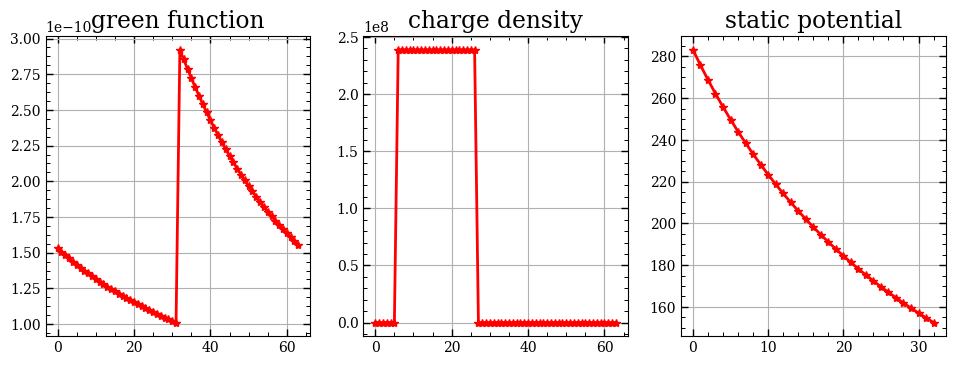

In [952]:
fig, [ax1, ax2, ax3] = plt.subplots(figsize = (12, 4), ncols = 3)
ax1.plot(GFC[:, Ny/2-1, Nz/2-1], '-*')
ax1.grid()
ax1.set_title(r'green function')
ax2.plot(RHOC[:, Ny/2-1, Nz/2-1], '-*')
ax2.grid()
ax2.set_title(r'charge density')
ax3.plot(PHI[:, Ny/2-1, Nz/2-1], '-*')
ax3.grid()
ax3.set_title(r'static potential')

In [953]:
Ex, Ey, Ez = np.gradient(PHI, hx, hy, hz)

(0, 500)

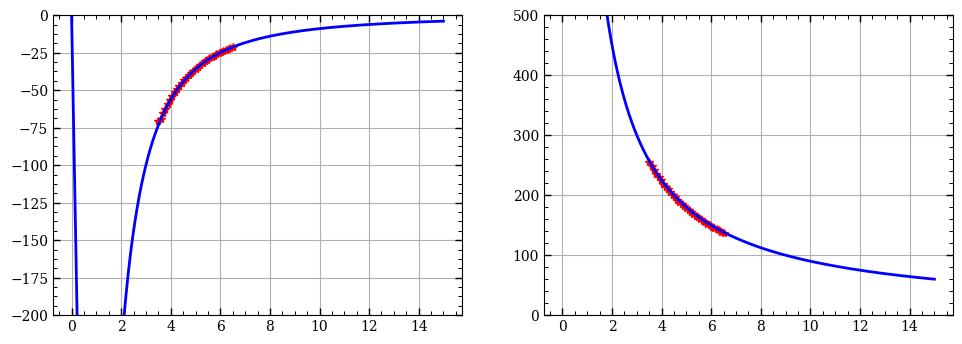

In [954]:
rr = np.linspace(-Nc*sigma_x, Nc*sigma_x, Nx+1)+hx/2.+xf

data = np.loadtxt('R1mm.dat')

fig, [ax1, ax2] = plt.subplots(figsize = (12, 4), ncols = 2)
ax1.plot((rr-hx/2)/sigma_x, Ex[:, Ny/2-1, Nz/2-1]*Qtot/4/np.pi/g_eps0/1e3, '-*')
ax1.plot(data[:,0]/sigma_x, -data[:,2]/1e3, '-')
ax1.set_ylim(-200, 0)
ax1.grid()

ax2.plot((rr-hx/2)/sigma_x, PHI[:, Ny/2-1, Nz/2-1]*Qtot/4/np.pi/g_eps0, '-*')
ax2.plot(data[:,0]/sigma_x, data[:,1], '-')
ax2.grid()
ax2.set_ylim(0, 500)

## Class-level scripts

In [221]:
def GF3D((x, y, z)):
    '''
    Green function (GF) in 3D cartesian CS
    '''
    r = np.sqrt(x*x+y*y+z*z)
    return np.where(r>0, 1./np.sqrt(x*x+y*y+z*z), 1e100)
def IGF3D((x, y, z)):
    '''
    Indefinite integral of or integrated green function in 3D cartesian CS, according to Eq.(2) on 129901-2. 
    Here, `indefinite` refers to the integrating limits
    ''' 
    r = np.sqrt(x*x+y*y+z*z)
    
    #EPS = 1e-12
    #if abs(r) < EPS:
    #    return 0
    #if abs(x) < EPS:
    #    return y*z*np.log(r)
    #if abs(y) < EPS:
    #    return z*x*np.log(r)
    #if abs(z) < EPS:
    #    return x*y*np.log(r)
    
    x2 = x*x; y2 = y*y; z2 = z*z
    xy = x*y; yz = y*z; zx = z*x
    s = yz*np.log(x+r)+zx*np.log(y+r)+xy*np.log(z+r)
    a = -0.5*x2*np.arctan(yz/x/r)
    b = -0.5*y2*np.arctan(zx/y/r)
    c = -0.5*z2*np.arctan(xy/z/r)
    return s+a+b+c
def shifted_IGF3D(x, y, z, xc = 0, yc = 0, zc = 0):
    return IGF3D(x+xc, y+yc, z+zc)
def cyclic_IGF3D_mapping((i, j, k), IGF_MAP):
    # n = np.array([-1, 1, 1, -1, 1, -1, -1, 1])
    # v = np.array([IGF_MAP[i, j, k], IGF_MAP[i, j, k+1],\
    #              IGF_MAP[i, j+1, k], IGF_MAP[i, j+1, k+1],\
    #              IGF_MAP[i+1, j, k], IGF_MAP[i+1, j, k+1],\
    #              IGF_MAP[i+1, j+1, k], IGF_MAP[i+1, j+1, k+1]])
    rr = -IGF_MAP[i, j, k] +IGF_MAP[i, j, k+1]  +IGF_MAP[i, j+1, k]  -IGF_MAP[i, j+1, k+1]+\
         IGF_MAP[i+1, j, k]-IGF_MAP[i+1, j, k+1]-IGF_MAP[i+1, j+1, k]+IGF_MAP[i+1, j+1, k+1]
    return rr

from scipy.interpolate import RegularGridInterpolator, Rbf
from numpy.fft import fftn, ifftn
import inspect

class SpaceCharge3DFFT():
    def __init__(self, nx = 32, ny = 32, nz = 32, N_cutoff = 5, debug = 0,\
                 Lspch = True, Lmirror = False, Lbin = False, Nbin = 1):
        
        self.nx = nx; self.ny = ny; self.nz = nz
        self.N_cutoff = N_cutoff       
        self.debug = debug
        
        self.Lspch = Lspch; self.Lmirror = Lmirror
        self.Lbin = Lbin; self.Nbin = Nbin
        
        return
    def get_rho_3D0(self, sigma_x = 1e-3, sigma_y = 1e-3, sigma_z = 1e-3, gamma0 = 1, Qtot = 100e-12):
        '''
        Set charge density to 3D gaussian distributions
        '''
        self.Qtot = Qtot
        self.gamma0 = gamma0
        
        sigma_z_static = sigma_z*gamma0
         
        Nx, Ny, Nz = self.nx, self.ny, self.nz
        N_cutoff = self.N_cutoff
        
        self.gamma0 = gamma0
        
        def rho_3D((x_static, y_static, z_static)):
            xc, yc, zc = 0, 0, 0
            f_x = 1./np.sqrt(2.*np.pi)/sigma_x*np.exp(-(x_static-xc)**2/2./sigma_x**2)
            f_y = 1./np.sqrt(2.*np.pi)/sigma_y*np.exp(-(y_static-yc)**2/2./sigma_y**2)
            f_z = 1./np.sqrt(2.*np.pi)/sigma_z*np.exp(-(z_static-zc)**2/2./sigma_z_static**2)
            
            return f_x*f_y*f_z
        
        xgrid = np.linspace(-N_cutoff*sigma_x, N_cutoff*sigma_x, Nx+1)
        ygrid = np.linspace(-N_cutoff*sigma_y, N_cutoff*sigma_y, Ny+1)
        zgrid_static = np.linspace(-N_cutoff*sigma_z_static, N_cutoff*sigma_z_static, Nz+1)
        
        XX = np.meshgrid(xgrid, ygrid, zgrid_static, indexing = 'ij')        
        rho = rho_3D(XX)
        
        self.dx = N_cutoff*2*sigma_x/Nx
        self.dy = N_cutoff*2*sigma_y/Ny
        self.dz = N_cutoff*2*sigma_z/Nz
        self.dz_static = self.dz*gamma0
        self.sigma_x = sigma_x
        self.sigma_y = sigma_y
        self.sigma_z = sigma_z
        self.sigma_z_static = self.sigma_z*gamma0
        
        self.xgrid = xgrid; self.ygrid = ygrid; self.zgrid_static = zgrid_static
        self.zmean = 0; self.zref = 0
        self.rho = rho
        return
    def get_rho_3D1(self, R = 1e-3, gamma0 = 5, Qtot = 100e-12):
        '''
        Set charge density to 3D uniform distributions confined in a sphere
        '''
        self.Qtot = Qtot
        self.gamma0 = gamma0
        
        sigma_x = R; sigma_y = R; sigma_z = R
        sigma_z_static = sigma_z*gamma0
        
        Nx, Ny, Nz = self.nx, self.ny, self.nz
        N_cutoff = self.N_cutoff  
        
        def rho_3D((x_static, y_static, z_static)):
            radius = R #*np.sqrt(15)/5.0;
            xc, yc, zc = 0, 0, 0
            r = np.sqrt((x_static-xc)**2+(y_static-yc)**2+(z_static/gamma0-zc)**2)
            rho = np.where(r>radius, 0, 3./(4*np.pi*radius**3))
            return rho
        
        xgrid = np.linspace(-N_cutoff*sigma_x, N_cutoff*sigma_x, Nx+1)
        ygrid = np.linspace(-N_cutoff*sigma_y, N_cutoff*sigma_y, Ny+1)
        zgrid_static = np.linspace(-N_cutoff*sigma_z_static, N_cutoff*sigma_z_static, Nz+1)
        
        XX = np.meshgrid(xgrid, ygrid, zgrid_static, indexing = 'ij')        
        rho = rho_3D(XX)
        
        self.dx = N_cutoff*2*sigma_x/Nx
        self.dy = N_cutoff*2*sigma_y/Ny
        self.dz = N_cutoff*2*sigma_z/Nz
        self.dz_static = self.dz*gamma0
        self.sigma_x = sigma_x
        self.sigma_y = sigma_y
        self.sigma_z = sigma_z
        self.sigma_z_static = self.sigma_z*gamma0
        
        self.xgrid = xgrid; self.ygrid = ygrid; self.zgrid_static = zgrid_static
        self.zmean = 0; self.zref = 1.5*R
        self.rho = rho
        return
    def get_rho_3D(self, dist, nx = None, ny = None, nz = None, N_cutoff = None, format = 'Astra'):
        if nx is not None:
            self.nx = nx
        if ny is not None:
            self.ny = ny
        if nz is not None:
            self.nz = nz
        Nx = self.nx; Ny = self.ny; Nz = self.nz
        if N_cutoff is not None:
            self.N_cutoff = N_cutoff
        N_cutoff = self.N_cutoff
        
        if format == 'Astra' or format == 'ASTRA' or format == 'astra':
            ix, iy, iz, iux, iuy, iuz, iw = 0, 1, 2, 3, 4, 5, 7
            
            self.zref = dist[0,iz]
            dist[0,iz] = 0
            
            #select = (dist[:,9]==5); dist = dist[select]
            x = dist[:,ix]
            y = dist[:,iy]
            z = dist[:,iz]
            w = dist[:,iw]; self.Qtot = np.sum(w)*1e-9
            
            self.zmean =  weighted_mean(z, w)
            z -= self.zmean
            
            bgx, bgy, bgz = dist[:,iux]/g_mec2/1e6, dist[:,iuy]/g_mec2/1e6, dist[:,iuz]/g_mec2/1e6

            gamma = np.sqrt(1+bgx**2+bgy**2+bgz**2)
            gamma0 = weighted_mean(gamma, w)
            z_static = z*gamma0

        self.gamma0 = gamma0;              #print inspect.stack()[0][3], 'gamma = ', self.gamma0
        self.sigma_x = weighted_std(x, w); #print inspect.stack()[0][3], 'sigma_x = ', self.sigma_x
        self.sigma_y = weighted_std(y, w); #print inspect.stack()[0][3], 'sigma_y = ', self.sigma_y
        self.sigma_z_static = weighted_std(z_static, w); #print inspect.stack()[0][3], 'sigma_z_static = ', self.sigma_z_static
        self.sigma_z = self.sigma_z_static/gamma0;       #print inspect.stack()[0][3], 'sigma_z = ', self.sigma_z
        
        xmin = np.max([np.min(x), -N_cutoff*self.sigma_x])
        xmax = np.min([np.max(x),  N_cutoff*self.sigma_x])
        ymin = np.max([np.min(y), -N_cutoff*self.sigma_y])
        ymax = np.min([np.max(y),  N_cutoff*self.sigma_y])
        zmin_static = np.max([np.min(z_static), -N_cutoff*self.sigma_z_static])
        zmax_static = np.min([np.max(z_static),  N_cutoff*self.sigma_z_static])
        
        n0 = 1 # Guarding grids on one side
        hx = (xmax-xmin)/(Nx-2*n0); hy = (ymax-ymin)/(Ny-2*n0)
        hz_static = (zmax_static-zmin_static)/(Nz-2*n0)
        self.dx = hx; self.dy = hy; self.dz_static = hz_static; #print inspect.stack()[0][3], 'mesh sizes: ', hx, hy, hz
        self.dz = hz_static/gamma0
        
        if self.debug:
            print inspect.stack()[0][3], 'Qtot = ', self.Qtot
            print inspect.stack()[0][3], 'gamma = ', self.gamma0
            print inspect.stack()[0][3], 'sigma_x = ', self.sigma_x
            print inspect.stack()[0][3], 'sigma_y = ', self.sigma_y
            print inspect.stack()[0][3], 'sigma_z_static = ', self.sigma_z_static
            print inspect.stack()[0][3], 'sigma_z = ', self.sigma_z
            print inspect.stack()[0][3], 'mesh sizes in rest frame: ', hx, hy, hz_static
        
        xgrid = np.linspace(xmin-n0*hx, xmax+n0*hx, Nx+1)
        ygrid = np.linspace(ymin-n0*hy, ymax+n0*hy, Ny+1)
        zgrid_static = np.linspace(zmin_static-n0*hz_static, zmax_static+n0*hz_static, Nz+1)
        
        ranges = [(xgrid[0]-0.5*hx, xgrid[-1]+0.5*hx), (ygrid[0]-0.5*hy, ygrid[-1]+0.5*hy),\
                  (zgrid_static[0]-0.5*hz_static, zgrid_static[-1]+0.5*hz_static)]
        rho, edges = np.histogramdd((x, y, z_static), bins = (Nx+1, Ny+1, Nz+1),\
                                    range = ranges, weights = w)
        
        if self.debug:
            #print xgrid/self.sigma_x, ygrid/self.sigma_y, zgrid/self.sigma_z_static
            #print rho
            #print ranges
            fig, [ax1, ax2] = plt.subplots(ncols = 2, figsize = (8, 4))
            data = np.abs(rho[:,Ny/2-1, Nz/2-1])
            ax1.plot(xgrid*1e3, data/np.max(data), '-*')
            ax1.grid()
            ax1.set_xlabel(r'$x$ (mm)')
            ax1.set_ylabel(r'$\rho$ (arb. unit)')
            
            [aX,aY] = np.meshgrid(xgrid, ygrid)
            data = np.abs(rho[:,:,Nz/2-1])
            v = np.linspace(0.05, 1., 96)
            ax2.contourf(aX*1e3, aY*1e3, data/np.max(data), v, linestyles = None)
            ax2.grid()
            ax2.set_xlabel(r'$x$ (mm)')
            ax2.set_ylabel(r'$y$ (mm)')
            
            fig.savefig('charge-density.eps')
        
        #rho = sgolay2d(rho, window_size=11, order=4)   
        #self.rho_RZ = interp2d(rr, zz, rho.T, kind = 'cubic')
        self.xgrid = xgrid
        self.ygrid = ygrid
        self.zgrid_static = zgrid_static
        self.rho = rho/np.sum(w)/(hx*hy*hz_static)
        return
    
    def build(self, Xshift = (0, 0, 0), N_cutoff = None):
        
        Nx = self.nx; Ny = self.ny; Nz = self.nz; 
        sigma_x = self.sigma_x; sigma_y = self.sigma_y; sigma_z_static = self.sigma_z_static
        #hx = self.dx; hy = self.dy; hz = self.dz_static
        
        if N_cutoff is None:
            N_cutoff = self.N_cutoff
        
        if self.Lspch:
            # Create arrays for GFs and densities
            GFC = np.zeros((2*Nx, 2*Ny, 2*Nz))
            RHOC = np.zeros((2*Nx, 2*Ny, 2*Nz))

            xgrid = self.xgrid
            ygrid = self.ygrid
            zgrid_static = self.zgrid_static
            RHOC[0:Nx+1, 0:Ny+1, 0:Nz+1] = self.rho

            hx = xgrid[1]-xgrid[0]; hy = ygrid[1]-ygrid[0]; hz_static = zgrid_static[1]-zgrid_static[0]
            if self.debug:
                print inspect.stack()[0][3], Nx, Ny, Nz
                print inspect.stack()[0][3], hx, hy, hz_static

            ## using vector to calculate GFs
            ## Calculate GFs by using the mapping, faster
            xf, yf, zf = Xshift
            xx = xf-Nx*hx+np.arange(2*Nx+1)*hx-0.5*hx
            yy = yf-Ny*hy+np.arange(2*Ny+1)*hy-0.5*hy
            zz_static = zf*self.gamma0-Nz*hz_static+np.arange(2*Nz+1)*hz_static-0.5*hz_static
            XX = np.meshgrid(xx, yy, zz_static, indexing = 'ij')
            IGF_MAP = IGF3D(XX)

            ii = np.mod(np.arange(2*Nx)+Nx, 2*Nx)
            jj = np.mod(np.arange(2*Ny)+Ny, 2*Ny)
            kk = np.mod(np.arange(2*Nz)+Nz, 2*Nz)
            II = np.meshgrid(ii, jj, kk, indexing = 'ij')
            GFC = cyclic_IGF3D_mapping(II, IGF_MAP)

            ## FFT convolution to get the static potenital: PHI
            GFC_FFT = fftn(GFC)
            RHOC_FFT = fftn(RHOC)
            PHIC_FFT = GFC_FFT*RHOC_FFT

            PHIC = ifftn(PHIC_FFT)
            self.PHI = PHIC[:Nx+1,:Ny+1,:Nz+1]
            
        if self.Lspch and self.Lmirror:
            zf = (self.zref+self.zmean)*2; print zf
            RHOC_mirror = RHOC[:,:,::-1]
            #zgrid = -self.zgrid[::-1]
        
            ## using vector to calculate GFs
            ## Calculate GFs by using the mapping, faster
            xx = xf-Nx*hx+np.arange(2*Nx+1)*hx-0.5*hx
            yy = yf-Ny*hy+np.arange(2*Ny+1)*hy-0.5*hy
            zz_static = zf*self.gamma0-Nz*hz_static+np.arange(2*Nz+1)*hz_static-0.5*hz_static
            XX = np.meshgrid(xx, yy, zz_static, indexing = 'ij')
            IGF_MAP = IGF3D(XX)

            ii = np.mod(np.arange(2*Nx)+Nx, 2*Nx)
            jj = np.mod(np.arange(2*Ny)+Ny, 2*Ny)
            kk = np.mod(np.arange(2*Nz)+Nz, 2*Nz)
            II = np.meshgrid(ii, jj, kk, indexing = 'ij')
            GFC = cyclic_IGF3D_mapping(II, IGF_MAP)

            ## FFT convolution to get the static potenital: PHI
            GFC_FFT = fftn(GFC)
            RHOC_FFT = fftn(RHOC)
            PHIC_FFT = GFC_FFT*RHOC_FFT

            PHIC_mirror = ifftn(PHIC_FFT)
            self.PHI_mirror = PHIC_mirror[:Nx+1,:Ny+1,:Nz+1]
            self.PHI -= self.PHI_mirror
            
        Ex_static, Ey_static, Ez_static = np.gradient(self.PHI, hx, hy, hz_static)     
        cc = -self.Qtot/4/np.pi/g_eps0
        
        if self.debug:
            print inspect.stack()[0][3], 'Qtot = ', self.Qtot
            fig, [ax1, ax2] = plt.subplots(figsize = (12, 4), ncols = 2)
            ax1.plot(xgrid/sigma_x, Ex_static[:, Ny/2-1, Nz/4-1]*cc/1e3, '-*')
            ax1.set_xlabel(r'$x/\sigma_x$')
            ax1.set_ylabel(r'$E_x(x)$ (kV/m)')
            ax1.grid()
            ax2.plot(zgrid_static/sigma_z_static, Ez_static[Nx/2-1, Ny/2-1, :]*cc/1e3, '-*')
            ax2.set_xlabel(r'$z/\sigma_z$')
            ax2.set_ylabel(r'$E_z(z)$ (kV/m)')
            ax2.grid()
            plt.tight_layout()
            fig.savefig('fields-on-axis.eps')
            
            fig, [ax1, ax2, ax3] = plt.subplots(figsize = (12, 4), ncols = 3)
            ax1.plot(GFC[:, Ny/2-1, Nz/2-1], '-*')
            ax1.grid()
            ax1.set_xlabel(r'grid number')
            ax1.set_title(r'green function')
            ax2.plot(RHOC[:, Ny/2-1, Nz/2-1], '-*')
            ax2.grid()
            ax2.set_xlabel(r'grid number')
            ax2.set_title(r'charge density')
            ax3.plot(self.PHI[:, Ny/2-1, Nz/2-1], '-*')
            ax3.grid()
            ax3.set_xlabel(r'grid number')
            ax3.set_title(r'static potential')
            plt.tight_layout()
            fig.savefig('green-function.eps')
        
        fEx3D_static = RegularGridInterpolator((xgrid, ygrid, zgrid_static), Ex_static, bounds_error = False, fill_value = None)
        fEy3D_static = RegularGridInterpolator((xgrid, ygrid, zgrid_static), Ey_static, bounds_error = False, fill_value = None)
        fEz3D_static = RegularGridInterpolator((xgrid, ygrid, zgrid_static), Ez_static, bounds_error = False, fill_value = None)
        
        gamma0 = self.gamma0; beta = gamma2beta(gamma0); z0 = self.zmean
        def EM3D(x, y, z, t = 0):
            z_static = (z-z0)*gamma0
            Ex_static = fEx3D_static((x, y, z_static))*cc
            Ey_static = fEy3D_static((x, y, z_static))*cc
            Ez_static = fEz3D_static((x, y, z_static))*cc
            # return normalied E and B in lab frame
            return [gamma0*Ex_static, gamma0*Ey_static, Ez_static, beta*gamma0*Ey_static, -beta*gamma0*Ex_static, 0]
        
        if self.debug and 0:
            X, Y, Z = np.meshgrid(xx, yy, zz, indexing = 'ij')

            fEx3D = Rbf(X, Y, Z, Ex, function = 'linear') # or X.ravel()
            fEy3D = Rbf(X, Y, Z, Ey, function = 'linear')
            fEz3D = Rbf(X, Y, Z, Ez, function = 'linear')

            gamma = self.gamma; beta = gamma2beta(gamma)
            def EM3D(x, y, z, t = 0):
                z = z*gamma
                Ex = fEx3D(x, y, z)*cc
                Ey = fEy3D(x, y, z)*cc
                Ez = fEz3D(x, y, z)*cc
                # return normalied E and B
                return [gamma*Ex, gamma*Ey, Ez, beta*gamma*Ey, -beta*gamma*Ex, 0]

        self.EM3D = EM3D
        return
    
    def get_rho_3D_binned(self, dist, nx = None, ny = None, nz = None, N_cutoff = None, format = 'Astra'):
        if nx is not None:
            self.nx = nx
        if ny is not None:
            self.ny = ny
        if nz is not None:
            self.nz = nz
        Nx = self.nx; Ny = self.ny; Nz = self.nz
        if N_cutoff is not None:
            self.N_cutoff = N_cutoff
        N_cutoff = self.N_cutoff
        
        if format == 'Astra' or format == 'ASTRA' or format == 'astra':
            ix, iy, iz, iux, iuy, iuz, iw = 0, 1, 2, 3, 4, 5, 7
            
            self.zref = dist[0,iz]
            dist[0,iz] = 0
            
            select = (dist[:,9]==5); dist = dist[select]
            x = dist[:,ix]
            y = dist[:,iy]
            z = dist[:,iz]
            w = dist[:,iw]; self.Qtot = np.sum(w)*1e-9
            
            self.zmean =  weighted_mean(z, w)
            z -= self.zmean
            
            bgx, bgy, bgz = dist[:,iux]/g_mec2/1e6, dist[:,iuy]/g_mec2/1e6, dist[:,iuz]/g_mec2/1e6

            gamma = np.sqrt(1+bgx**2+bgy**2+bgz**2)
            gamma0 = weighted_mean(gamma, w)
            z_static = z*gamma0

        self.gamma0 = gamma0;              #print inspect.stack()[0][3], 'gamma = ', self.gamma0
        self.sigma_x = weighted_std(x, w); #print inspect.stack()[0][3], 'sigma_x = ', self.sigma_x
        self.sigma_y = weighted_std(y, w); #print inspect.stack()[0][3], 'sigma_y = ', self.sigma_y
        self.sigma_z_static = weighted_std(z_static, w); #print inspect.stack()[0][3], 'sigma_z_static = ', self.sigma_z_static
        self.sigma_z = self.sigma_z_static/gamma0;       #print inspect.stack()[0][3], 'sigma_z = ', self.sigma_z
        
        xmin = np.max([np.min(x), -N_cutoff*self.sigma_x])
        xmax = np.min([np.max(x),  N_cutoff*self.sigma_x])
        ymin = np.max([np.min(y), -N_cutoff*self.sigma_y])
        ymax = np.min([np.max(y),  N_cutoff*self.sigma_y])
        zmin_static = np.max([np.min(z_static), -N_cutoff*self.sigma_z_static])
        zmax_static = np.min([np.max(z_static),  N_cutoff*self.sigma_z_static])
        
        n0 = 1 # Guarding grids on one side
        hx = (xmax-xmin)/(Nx-2*n0); hy = (ymax-ymin)/(Ny-2*n0)
        hz_static = (zmax_static-zmin_static)/(Nz-2*n0)
        self.dx = hx; self.dy = hy; self.dz_static = hz_static; #print inspect.stack()[0][3], 'mesh sizes: ', hx, hy, hz
        self.dz = hz_static/gamma0
        
        if self.debug:
            print inspect.stack()[0][3], 'Qtot = ', self.Qtot
            print inspect.stack()[0][3], 'gamma = ', self.gamma0
            print inspect.stack()[0][3], 'sigma_x = ', self.sigma_x
            print inspect.stack()[0][3], 'sigma_y = ', self.sigma_y
            print inspect.stack()[0][3], 'sigma_z_static = ', self.sigma_z_static
            print inspect.stack()[0][3], 'sigma_z = ', self.sigma_z
            print inspect.stack()[0][3], 'mesh sizes in rest frame: ', hx, hy, hz_static
        
        xgrid = np.linspace(xmin-n0*hx, xmax+n0*hx, Nx+1)
        ygrid = np.linspace(ymin-n0*hy, ymax+n0*hy, Ny+1)
        zgrid_static = np.linspace(zmin_static-n0*hz_static, zmax_static+n0*hz_static, Nz+1)
        
        ranges = [(xgrid[0]-0.5*hx, xgrid[-1]+0.5*hx), (ygrid[0]-0.5*hy, ygrid[-1]+0.5*hy),\
                  (zgrid_static[0]-0.5*hz_static, zgrid_static[-1]+0.5*hz_static)]
        rho, edges = np.histogramdd((x, y, z_static), bins = (Nx+1, Ny+1, Nz+1),\
                                    range = ranges, weights = w)
        
        if self.debug:
            #print xgrid/self.sigma_x, ygrid/self.sigma_y, zgrid/self.sigma_z_static
            #print rho
            #print ranges
            fig, [ax1, ax2] = plt.subplots(ncols = 2, figsize = (8, 4))
            data = np.abs(rho[:,Ny/2-1, Nz/2-1])
            ax1.plot(xgrid*1e3, data/np.max(data), '-*')
            ax1.grid()
            ax1.set_xlabel(r'$x$ (mm)')
            ax1.set_ylabel(r'$\rho$ (arb. unit)')
            
            [aX,aY] = np.meshgrid(xgrid, ygrid)
            data = np.abs(rho[:,:,Nz/2-1])
            v = np.linspace(0.05, 1., 96)
            ax2.contourf(aX*1e3, aY*1e3, data/np.max(data), v, linestyles = None)
            ax2.grid()
            ax2.set_xlabel(r'$x$ (mm)')
            ax2.set_ylabel(r'$y$ (mm)')
            
            fig.savefig('charge-density.eps')
        
        #rho = sgolay2d(rho, window_size=11, order=4)   
        #self.rho_RZ = interp2d(rr, zz, rho.T, kind = 'cubic')
        self.xgrid = xgrid
        self.ygrid = ygrid
        self.zgrid_static = zgrid_static
        self.rho = rho/np.sum(w)/(hx*hy*hz_static)
        return
    
    def build_binned(self, Xshift = (0, 0, 0), N_cutoff = None):
        
        Nx = self.nx; Ny = self.ny; Nz = self.nz; 
        sigma_x = self.sigma_x; sigma_y = self.sigma_y; sigma_z_static = self.sigma_z_static
        #hx = self.dx; hy = self.dy; hz = self.dz_static
        
        if N_cutoff is None:
            N_cutoff = self.N_cutoff
        
        if self.Lspch:
            # Create arrays for GFs and densities
            GFC = np.zeros((2*Nx, 2*Ny, 2*Nz))
            RHOC = np.zeros((2*Nx, 2*Ny, 2*Nz))

            xgrid = self.xgrid
            ygrid = self.ygrid
            zgrid_static = self.zgrid_static
            RHOC[0:Nx+1, 0:Ny+1, 0:Nz+1] = self.rho

            hx = xgrid[1]-xgrid[0]; hy = ygrid[1]-ygrid[0]; hz_static = zgrid_static[1]-zgrid_static[0]
            if self.debug:
                print inspect.stack()[0][3], Nx, Ny, Nz
                print inspect.stack()[0][3], hx, hy, hz_static

            ## using vector to calculate GFs
            ## Calculate GFs by using the mapping, faster
            xf, yf, zf = Xshift
            xx = xf-Nx*hx+np.arange(2*Nx+1)*hx-0.5*hx
            yy = yf-Ny*hy+np.arange(2*Ny+1)*hy-0.5*hy
            zz_static = zf*self.gamma0-Nz*hz_static+np.arange(2*Nz+1)*hz_static-0.5*hz_static
            XX = np.meshgrid(xx, yy, zz_static, indexing = 'ij')
            IGF_MAP = IGF3D(XX)

            ii = np.mod(np.arange(2*Nx)+Nx, 2*Nx)
            jj = np.mod(np.arange(2*Ny)+Ny, 2*Ny)
            kk = np.mod(np.arange(2*Nz)+Nz, 2*Nz)
            II = np.meshgrid(ii, jj, kk, indexing = 'ij')
            GFC = cyclic_IGF3D_mapping(II, IGF_MAP)

            ## FFT convolution to get the static potenital: PHI
            GFC_FFT = fftn(GFC)
            RHOC_FFT = fftn(RHOC)
            PHIC_FFT = GFC_FFT*RHOC_FFT

            PHIC = ifftn(PHIC_FFT)
            self.PHI = PHIC[:Nx+1,:Ny+1,:Nz+1]
            
        if self.Lspch and self.Lmirror:
            zf = (self.zref+self.zmean)*2; print zf
            RHOC_mirror = RHOC[:,:,::-1]
            #zgrid = -self.zgrid[::-1]
        
            ## using vector to calculate GFs
            ## Calculate GFs by using the mapping, faster
            xx = xf-Nx*hx+np.arange(2*Nx+1)*hx-0.5*hx
            yy = yf-Ny*hy+np.arange(2*Ny+1)*hy-0.5*hy
            zz_static = zf*self.gamma0-Nz*hz_static+np.arange(2*Nz+1)*hz_static-0.5*hz_static
            XX = np.meshgrid(xx, yy, zz_static, indexing = 'ij')
            IGF_MAP = IGF3D(XX)

            ii = np.mod(np.arange(2*Nx)+Nx, 2*Nx)
            jj = np.mod(np.arange(2*Ny)+Ny, 2*Ny)
            kk = np.mod(np.arange(2*Nz)+Nz, 2*Nz)
            II = np.meshgrid(ii, jj, kk, indexing = 'ij')
            GFC = cyclic_IGF3D_mapping(II, IGF_MAP)

            ## FFT convolution to get the static potenital: PHI
            GFC_FFT = fftn(GFC)
            RHOC_FFT = fftn(RHOC)
            PHIC_FFT = GFC_FFT*RHOC_FFT

            PHIC_mirror = ifftn(PHIC_FFT)
            self.PHI_mirror = PHIC_mirror[:Nx+1,:Ny+1,:Nz+1]
            self.PHI -= self.PHI_mirror
            
        Ex_static, Ey_static, Ez_static = np.gradient(self.PHI, hx, hy, hz_static)     
        cc = -self.Qtot/4/np.pi/g_eps0
        
        if self.debug:
            print inspect.stack()[0][3], 'Qtot = ', self.Qtot
            fig, [ax1, ax2] = plt.subplots(figsize = (12, 4), ncols = 2)
            ax1.plot(xgrid/sigma_x, Ex_static[:, Ny/2-1, Nz/4-1]*cc/1e3, '-*')
            ax1.set_xlabel(r'$x/\sigma_x$')
            ax1.set_ylabel(r'$E_x(x)$ (kV/m)')
            ax1.grid()
            ax2.plot(zgrid_static/sigma_z_static, Ez_static[Nx/2-1, Ny/2-1, :]*cc/1e3, '-*')
            ax2.set_xlabel(r'$z/\sigma_z$')
            ax2.set_ylabel(r'$E_z(z)$ (kV/m)')
            ax2.grid()
            plt.tight_layout()
            fig.savefig('fields-on-axis.eps')
            
            fig, [ax1, ax2, ax3] = plt.subplots(figsize = (12, 4), ncols = 3)
            ax1.plot(GFC[:, Ny/2-1, Nz/2-1], '-*')
            ax1.grid()
            ax1.set_xlabel(r'grid number')
            ax1.set_title(r'green function')
            ax2.plot(RHOC[:, Ny/2-1, Nz/2-1], '-*')
            ax2.grid()
            ax2.set_xlabel(r'grid number')
            ax2.set_title(r'charge density')
            ax3.plot(self.PHI[:, Ny/2-1, Nz/2-1], '-*')
            ax3.grid()
            ax3.set_xlabel(r'grid number')
            ax3.set_title(r'static potential')
            plt.tight_layout()
            fig.savefig('green-function.eps')
        
        fEx3D_static = RegularGridInterpolator((xgrid, ygrid, zgrid_static), Ex_static, bounds_error = False, fill_value = None)
        fEy3D_static = RegularGridInterpolator((xgrid, ygrid, zgrid_static), Ey_static, bounds_error = False, fill_value = None)
        fEz3D_static = RegularGridInterpolator((xgrid, ygrid, zgrid_static), Ez_static, bounds_error = False, fill_value = None)
        
        gamma0 = self.gamma0; beta = gamma2beta(gamma0); z0 = self.zmean
        def EM3D(x, y, z, t = 0):
            z_static = (z-z0)*gamma0
            Ex_static = fEx3D_static((x, y, z_static))*cc
            Ey_static = fEy3D_static((x, y, z_static))*cc
            Ez_static = fEz3D_static((x, y, z_static))*cc
            # return normalied E and B in lab frame
            return [gamma0*Ex_static, gamma0*Ey_static, Ez_static, beta*gamma0*Ey_static, -beta*gamma0*Ex_static, 0]
        
        if self.debug and 0:
            X, Y, Z = np.meshgrid(xx, yy, zz, indexing = 'ij')

            fEx3D = Rbf(X, Y, Z, Ex, function = 'linear') # or X.ravel()
            fEy3D = Rbf(X, Y, Z, Ey, function = 'linear')
            fEz3D = Rbf(X, Y, Z, Ez, function = 'linear')

            gamma = self.gamma; beta = gamma2beta(gamma)
            def EM3D(x, y, z, t = 0):
                z = z*gamma
                Ex = fEx3D(x, y, z)*cc
                Ey = fEy3D(x, y, z)*cc
                Ez = fEz3D(x, y, z)*cc
                # return normalied E and B
                return [gamma*Ex, gamma*Ey, Ez, beta*gamma*Ey, -beta*gamma*Ex, 0]

        self.EM3D = EM3D
        return

build 32 32 32
build 0.00018750000000000017 0.00018750000000000017 0.0009375000000000008
0.003
build Qtot =  1e-10
time elapsed 0.942527599997


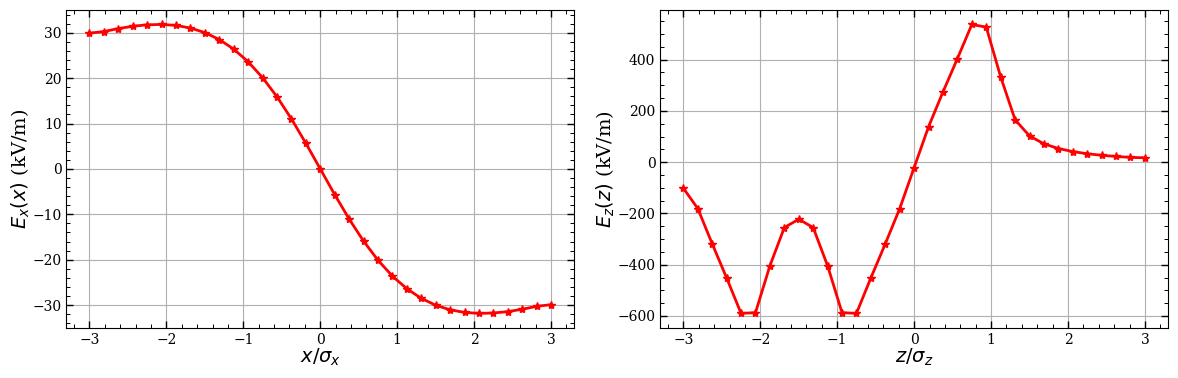

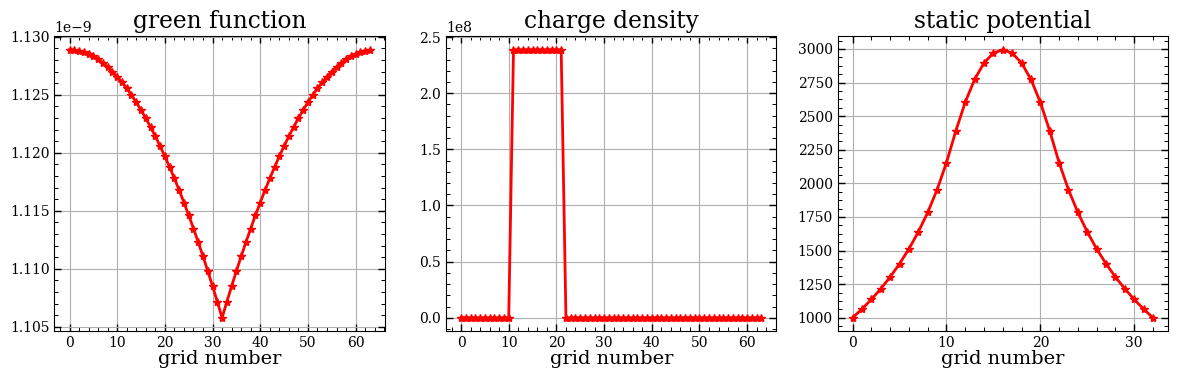

In [167]:
workdir = r'\\afs\ifh.de\group\pitz\data\lixiangk\work\sync\python\space-charge'
os.chdir(workdir)

dist = np.loadtxt('ast.0528.999')
dist[0,2] = 0; dist[1:,5] += dist[0,5]

Qtot = 100e-12
sigma_x = 1e-3; sigma_y = 1e-3; sigma_z = 1e-3
Nx, Ny, Nz = 32, 32, 32
Nc = 3
gamma0 = 1. #+150./g_mec2; print gamma

xf, yf, zf = 0*sigma_x, 0, 0

import timeit
sc3d = SpaceCharge3DFFT(Nx, Ny, Nz, Nc, debug = 1, Lmirror = True)
time1 = timeit.default_timer()
sc3d.get_rho_3D1()
#sc3d.get_rho_3D(dist = dist)
sc3d.build(Xshift = (xf, yf, zf))
#sc3d.build_mirror(zc = 0, xc = sigma_x*5, yc = sigma_y*5)
time2 = timeit.default_timer()
print 'time elapsed', time2-time1

In [ ]:
def demo(sc3d):
    sigma_x, sigma_y, sigma_z = sc3d.sigma_x, sc3d.sigma_y, sc3d.sigma_z
    Nx, Ny, Nz, Nc = sc3d.nx, sc3d.ny, sc3d.nz, sc3d.N_cutoff
    print sigma_x, sigma_y, sigma_z

    z0 = sc3d.zmean
    xx = np.linspace(-Nc*sigma_x, Nc*sigma_x, 2*Nx+1)+xf; #print xx
    yy = np.linspace(-Nc*sigma_y, Nc*sigma_y, 2*Ny+1); #print yy
    zz = np.linspace(-Nc*sigma_z, Nc*sigma_z, 2*Nz+1)+z0; #print zz
    zz = sc3d.zgrid/sc3d.gamma0

    fig, ax = plt.subplots(figsize = (6, 4))
    ax.plot(xx/sigma_x,\
            np.array([sc3d.EM3D(x, 0, z0+0*sigma_z)[0] for x in xx])/1e3, '-*')
    ax.plot(xx/sigma_x,\
            np.array([sc3d.EM3D(x, 0, z0+1*sigma_z)[0] for x in xx])/1e3, '-o')
    ax.plot(xx/sigma_x,\
            np.array([sc3d.EM3D(x, 0, z0+2*sigma_z)[0] for x in xx])/1e3, '-^')
    ax.plot(xx/sigma_x,\
            np.array([sc3d.EM3D(x, 0, z0-1*sigma_z)[0] for x in xx])/1e3, '-o')
    ax.plot(xx/sigma_x,\
            np.array([sc3d.EM3D(x, 0, z0-2*sigma_z)[0] for x in xx])/1e3, '-^')
    ax.set_xlim(-Nc, Nc)
    #ax.set_ylim(-200, 200)
    #ax.set_yticks(np.linspace(-200, 200, 11))
    ax.grid()
    ax.set_xlabel(r'$x/\sigma_x$')
    ax.set_ylabel(r'$E_x(x)$ (kV/m)')
    ax.legend([r'$\sigma_z/z = 0$', r'$\sigma_z/z = 1$', r'$\sigma_z/z = 2$', r'$\sigma_z/z = -1$', r'$\sigma_z/z = -2$'])
    fig.savefig('Ex-x-z.eps')

    fig, ax = plt.subplots(figsize = (6, 4))
    ax.plot(yy/sigma_y,\
            np.array([sc3d.EM3D(0, y, 0*sigma_z)[1] for y in yy])/1e3, '-*')
    ax.plot(yy/sigma_y,\
            np.array([sc3d.EM3D(0, y, 1*sigma_z)[1] for y in yy])/1e3, '-o')
    ax.plot(yy/sigma_y,\
            np.array([sc3d.EM3D(0, y, 2*sigma_z)[1] for y in yy])/1e3, '-^')
    ax.plot(yy/sigma_y,\
            np.array([sc3d.EM3D(0, y,-1*sigma_z)[1] for y in yy])/1e3, '-o')
    ax.plot(yy/sigma_y,\
            np.array([sc3d.EM3D(0, y,-2*sigma_z)[1] for y in yy])/1e3, '-^')
    ax.set_xlim(-Nc, Nc)
    #ax.set_ylim(-200, 200)
    ax.grid()
    ax.set_xlabel(r'$y/\sigma_y$')
    ax.set_ylabel(r'$E_y(y)$ (kV/m)')
    ax.legend([r'$\sigma_z/z = 0$', r'$\sigma_z/z = 1$', r'$\sigma_z/z = 2$', r'$\sigma_z/z = -1$', r'$\sigma_z/z = -2$'])
    fig.savefig('Ey-y-z.eps')

    fig, ax = plt.subplots(figsize = (6, 4))
    ax.plot(zz, np.array([sc3d.EM3D(0, 0, z)[2] for z in zz])/1e3, '-.')
    ax.plot(zz, np.array([sc3d.EM3D(sigma_x*0.375, 0, z)[2] for z in zz])/1e3, '-*')
    ax.plot(zz, np.array([sc3d.EM3D(sigma_x*0.750, 0, z)[2] for z in zz])/1e3, '-o')
    ax.plot(zz, np.array([sc3d.EM3D(sigma_x*1.125, 0, z)[2] for z in zz])/1e3, '-^')
    ax.plot(zz, np.array([sc3d.EM3D(sigma_x*1.500, 0, z)[2] for z in zz])/1e3, '-<')
    #ax.set_xlim(-Nc, Nc)
    #ax.set_ylim(-200, 200)
    ax.grid()
    ax.set_xlabel(r'$z$')
    ax.set_ylabel(r'$E_z(z)$ (kV/m)')
    ax.legend([r'$r/\sigma_x = 0$', r'$r/\sigma_x = 0.375$', r'$r/\sigma_x = 0.750$',\
               r'$r/\sigma_x = 1.125$', r'$r/\sigma_x = 1.500$'])
    fig.savefig('Ez-z-x.eps')
    return
demo(sc3d)

0.001 0.001 0.001


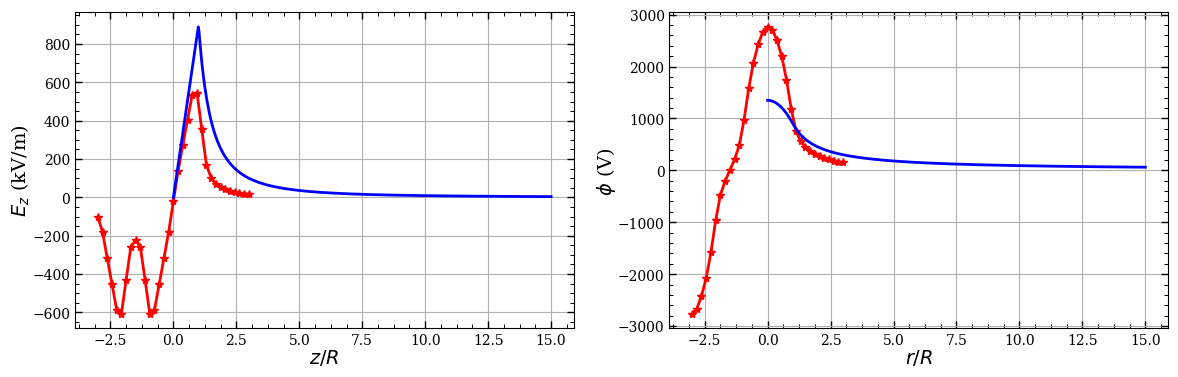

In [169]:
def demo2(sc3d):
    sigma_x, sigma_y, sigma_z = sc3d.sigma_x, sc3d.sigma_y, sc3d.sigma_z
    
    Nx, Ny, Nz, Nc = sc3d.nx, sc3d.ny, sc3d.nz, sc3d.N_cutoff
    print sigma_x, sigma_y, sigma_z

    zz = np.linspace(-Nc*sigma_z, Nc*sigma_z, Nz+1); #print xx
    Ez = np.array([sc3d.EM3D(0, 0, z)[2] for z in zz])

    data = np.loadtxt('R1mm.dat')

    fig, [ax1, ax2] = plt.subplots(figsize = (12, 4), ncols = 2)
    ax1.plot((zz+0)/sigma_z, Ez/1e3, '-*')
    ax1.plot(data[:,0]/sigma_z, data[:,2]/1e3, '-')
    #ax1.set_ylim(-200, 0)
    ax1.grid()
    ax1.set_xlabel(r'$z/R$')
    ax1.set_ylabel(r'$E_z$ (kV/m)')
    
    ax2.plot((zz+0)/sigma_z, sc3d.PHI[Nx/2-1, Ny/2-1, :]*Qtot/4/np.pi/g_eps0, '-*')
    ax2.plot(data[:,0]/sigma_z, data[:,1], '-')
    ax2.grid()
    #ax2.set_ylim(0, 500)
    ax2.set_xlabel(r'$r/R$')
    ax2.set_ylabel(r'$\phi$ (V)')
    
    plt.tight_layout()
    fig.savefig('field-on-axis-from-uniform-ball2.eps')
    return
demo2(sc3d)

# Tracking

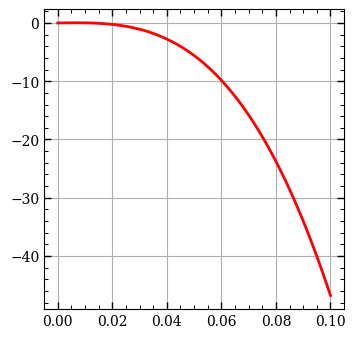

In [321]:
def build_cavity(filename, z0, amp, freq, phi0):
    #print phi_0
    data = np.loadtxt(filename)
    
    a, b = np.max(data[:,1]), np.min(data[:,1])
    Ez_z = data[:,1]/a*amp
    
    dz = data[1,0]-data[0,0]
    
    dEz_dz1 = np.gradient(   Ez_z, dz)
    dEz_dz2 = np.gradient(dEz_dz1, dz)
    dEz_dz3 = np.gradient(dEz_dz2, dz)
    
    fEz_0 = interp1d(data[:,0],    Ez_z, bounds_error = False, fill_value = 0)
    fEz_1 = interp1d(data[:,0], dEz_dz1, bounds_error = False, fill_value = 0)
    fEz_2 = interp1d(data[:,0], dEz_dz2, bounds_error = False, fill_value = 0)
    fEz_3 = interp1d(data[:,0], dEz_dz3, bounds_error = False, fill_value = 0)
    
    def EM3D(x, y, z, t = 0):
        omega = 2.*np.pi*freq
        phi = phi0*np.pi/180

        cc = omega**2/g_c**2
        
        r = np.sqrt(x*x+y*y)
        
        z1 = z-z0
        Ez0 = fEz_0(z1)
        Ez1 = fEz_1(z1)
        Ez2 = fEz_2(z1)
        Ez3 = fEz_3(z1)
        
        Ez = (     Ez0-r**2/4. *(Ez2+cc*Ez0))*np.sin(omega*t+phi)
        Er = (-0.5*Ez1+r**2/16.*(Ez3+cc*Ez1))*np.sin(omega*t+phi) # Er/r instead of Er
        Bt = ( 0.5*Ez0-r**2/16.*(Ez2+cc*Ez0))*cc/omega*np.cos(omega*t+phi) # Bt/r instead of Bt
        
        return [x*Er, y*Er, Ez, -y*Bt, x*Bt, 0]
    return EM3D
def build_solenoid(filename, z0, amp):
    
    data = np.loadtxt(filename)
    
    a, b = np.max(data[:,1]), np.min(data[:,1])
    Fz_z = data[:,1]/a*amp
    
    dz = data[1,0]-data[0,0]
    
    dFz_dz1 = np.gradient(Fz_z, dz)
    dFz_dz2 = np.gradient(dFz_dz1, dz)
    dFz_dz3 = np.gradient(dFz_dz2, dz)
    dFz_dz4 = np.gradient(dFz_dz3, dz)
    dFz_dz5 = np.gradient(dFz_dz4, dz)
    dFz_dz6 = np.gradient(dFz_dz5, dz)
    
    fFz_0 = interp1d(data[:,0], Fz_z,    bounds_error = False, fill_value = 0)
    fFz_1 = interp1d(data[:,0], dFz_dz1, bounds_error = False, fill_value = 0)
    fFz_2 = interp1d(data[:,0], dFz_dz2, bounds_error = False, fill_value = 0)
    fFz_3 = interp1d(data[:,0], dFz_dz3, bounds_error = False, fill_value = 0)
    fFz_4 = interp1d(data[:,0], dFz_dz4, bounds_error = False, fill_value = 0)
    fFz_5 = interp1d(data[:,0], dFz_dz5, bounds_error = False, fill_value = 0)
    fFz_6 = interp1d(data[:,0], dFz_dz6, bounds_error = False, fill_value = 0)
    
    def EM3D(x, y, z, t = 0):
        
        r = np.sqrt(x*x+y*y)
        
        z1 = z-z0
        Fz0 = fFz_0(z1)
        Fz1 = fFz_1(z1)
        Fz2 = fFz_2(z1)
        Fz3 = fFz_3(z1)
        Fz4 = fFz_4(z1)
        Fz5 = fFz_5(z1)
        Fz6 = fFz_6(z1)
        
        Bz = Fz0-r*r/4.*Fz2+r**4/64.*Fz4-r**6/2034.*Fz6
        Br = -1/2.*Fz1+r**2/16.*Fz3-r**4/384.*Fz5 # Br/r instead of Br
        
        return [0, 0, 0, x*Br, y*Br, Bz]
    return EM3D

class EMsolver():
    def __init__(self):
        self.em3d = {}
    def add_external_field(self, name, func):
        self.em3d.update({name:func})
    def get_field(self, x, y, z, t = 0):
        field = [0, 0, 0, 0, 0, 0]
        for name, func in self.em3d.iteritems():
            field = np.add(field, func(x, y, z, t))
        return field

field_maps = r'\\afs\ifh.de\group\pitz\data\lixiangk\work\sync\field-maps'
gun3d = build_cavity(field_maps+os.sep+'gun42Cavity.txt', 0, 60, 1.3e9, 90)
sol3d = build_solenoid(field_maps+os.sep+'gunsolenoidsPITZ.txt', 0, 0.2)

em = EMsolver()
em.add_external_field('gun', gun3d)
em.add_external_field('solenoid', sol3d)

rr = np.linspace(0, 0.1, 200)
ff = np.array([em.get_field(v, 0, 0)[0] for v in rr])

fig, ax = plt.subplots()
ax.plot(rr, ff, '-')
ax.grid()

In [355]:
class Beam():
    def __init__(self, fname = None, dist = None, debug = 0):
        self.diag = BeamDiagnostics(fname, dist)
        self.sc3d = SpaceCharge3DFFT(debug = debug)
        
        #self.key_value = {'x':0, 'ux':1, 'y':2, 'uy':3, 'z':4, 'uz':5, 'w':6}
        self.key_value = {'x':0, 'y':1, 'z':2, 'Px':3, 'Py':4, 'Pz':5, 'w':7}
        
        if fname is not None:
            self.dist = np.loadtxt(fname)
            self.dist[1:,2] += self.dist[0,2]
            self.dist[1:,5] += self.dist[0,5]
        elif dist is not None:
            self.dist = dist
        else:
            self.dist = []
        
        return
    def load(self, fname):
        self.diag = BeamDiagnostics(fname)
        self.dist = np.loadtxt(fname)
        
        # with open('beam.post.dat','a') as f_handle:
        #    np.savetxt(f_handle,np.atleast_2d(self.stat),fmt='%14.6E')
        return
    def get(self, i):
        return self.dist[i,:]
    def dump(self, fname):
        np.savetxt(fname, self.dist, fmt = '%15.6E')
        return
    def get_sc3d(self):
        self.sc3d.get_rho_3D(dist = self.dist)
        self.sc3d.build()
        return self.sc3d.EM3D

In [376]:
def unwrap_step_i(arg, **kwarg):
    return Tracking.step_i(*arg, **kwarg)

class Tracking():
    def __init__(self, beam, em3d, t1, dt = 1e-12, t0 = 0, out_inteval = 100):
        self.beam = beam
        self.em3d = em3d
        
        self.time = t0
        self.dt = dt
        self.tend = t1
        self.stepped = 0
        self.out_inteval = out_inteval
        return
    
    def deriv0(self, t, y):
        '''t -> time/s; y[0] -> x/m; y[1] -> bg_x; y[2] -> y/m; y[3] -> bg_x; y[4] -> z/m; y[5] -> bg_z'''
        Ex, Ey, Ez, Bx, By, Bz = self.em3d.get_field(y[0], y[2], y[4], t)

        bgx, bgy, bgz = y[1], y[3], y[5]
        gamma = np.sqrt(1+bgx**2+bgy**2+bgz**2)

        dydt = [0, 0, 0, 0, 0, 0]
        dydt[0] = y[1]*g_c/gamma
        dydt[1] = (bgy*Bz-bgz*By+Ex/g_c*gamma)/gamma/g_me*g_qe
        dydt[2] = y[3]*g_c/gamma
        dydt[3] = (bgz*Bx-bgx*Bz+Ey/g_c*gamma)/gamma/g_me*g_qe
        dydt[4] = y[5]*g_c/gamma
        dydt[5] = (bgx*By-bgy*Bx+Ez/g_c*gamma)/gamma/g_me*g_qe

        return dydt
    
    def deriv0(self, t, y):
        '''
        Parameters
          t: time/s
          y[0]: x/m
          y[1]: y/m
          y[2]: z/m
          y[3]: P_x*c
          y[4]: P_y*c
          y[5]: P_z*c
        Returns
          derivatives of y with respect to t
        '''
        Ex, Ey, Ez, Bx, By, Bz = self.em3d.get_field(y[0], y[1], y[2], t)

        Pxc, Pyc, Pzc = y[3], y[4], y[5]
        g_mec2_eV = g_mec2*1e6
        gamma = np.sqrt(g_mec2_eV**2+Pxc**2+Pyc**2+Pzc**2)/g_mec2_eV

        dydt = [0, 0, 0, 0, 0, 0]
        dydt[0] = Pxc*g_c/gamma/g_mec2_eV
        dydt[1] = Pyc*g_c/gamma/g_mec2_eV
        dydt[2] = Pzc*g_c/gamma/g_mec2_eV
        dydt[3] = (Pyc*Bz-Pzc*By+g_mec2_eV*Ex/g_c*gamma)/gamma/g_me*g_qe
        dydt[4] = (Pzc*Bx-Pxc*Bz+g_mec2_eV*Ey/g_c*gamma)/gamma/g_me*g_qe
        dydt[5] = (Pxc*By-Pyc*Bx+g_mec2_eV*Ez/g_c*gamma)/gamma/g_me*g_qe

        return dydt
    
    def deriv(self, t, y):
        '''
        Parameters
          t: time/s
          y[0]: x/m
          y[1]: y/m
          y[2]: z/m
          y[3]: P_x*c
          y[4]: P_y*c
          y[5]: P_z*c
        Returns
          derivatives of y with respect to t
        '''
        Ex, Ey, Ez, Bx, By, Bz = self.em3d.get_field(y[0], y[1], y[2], t)

        y = np.reshape(y, (len(y)/6, 6))
        Pxc, Pyc, Pzc = y[:,3], y[:,4], y[:,5]
        g_mec2_eV = g_mec2*1e6
        gamma = np.sqrt(g_mec2_eV**2+Pxc**2+Pyc**2+Pzc**2)/g_mec2_eV

        #dydt = [0, 0, 0, 0, 0, 0]
        dydt = np.zeros((len(y), 6))
        dydt[:,0] = Pxc*g_c/gamma/g_mec2_eV
        dydt[:,1] = Pyc*g_c/gamma/g_mec2_eV
        dydt[:,2] = Pzc*g_c/gamma/g_mec2_eV
        dydt[:,3] = (Pyc*Bz-Pzc*By+g_mec2_eV*Ex/g_c*gamma)/gamma/g_me*g_qe
        dydt[:,4] = (Pzc*Bx-Pxc*Bz+g_mec2_eV*Ey/g_c*gamma)/gamma/g_me*g_qe
        dydt[:,5] = (Pxc*By-Pyc*Bx+g_mec2_eV*Ez/g_c*gamma)/gamma/g_me*g_qe

        return dydt.flatten()
    
    def step_i(self, i):
        y0 = self.get(i)
        t0 = self.time

        r = ode(self.deriv).set_integrator('dopri5')
        r.set_initial_value(y0, t0).set_f_params()
        r.integrate(r.t+self.dt)

        # self.set(i, r.y)
        return r.y

    def step0(self, nstep = 1, num_cores=1):
        '''return (x, bgx, y, bgy, z, byz, t)'''
        
        #self.beam.get_sc3d()
        #self.em3d.add_external_field('spacecharge', sc3d)
        print nstep
        while nstep>0:
            self.stepped += 1

            if num_cores>1:
                # multi-core run
                # num = np.arange(self.NP)
                # results = Parallel(n_jobs=num_cores)(delayed(unwrap_step_i)(i) for i in zip([self]*len(num), num))
                # self.update(results)
                pass
            else:
                # run with one core
                r = ode(self.deriv).set_integrator('dopri5')
                for i, Y in enumerate(self.beam.dist):
                    y0 = Y[0:6]
                    t0 = self.time
                    
                    r.set_initial_value(y0, t0).set_f_params()
                    r.integrate(r.t+self.dt)
                    #self.set(i, r.y)
                    self.beam.dist[i,0:6] = r.y

            self.time += self.dt
            nstep = nstep-1
            # self.update_sc()
            if self.stepped % self.out_inteval == 0:
                self.beam.dump('trk.%06d.001' % self.stepped)
        print str.format('iter = %6d, time = %12.6E' % (self.stepped, self.time))
        return
    
    def step(self, nstep = 1, num_cores=1):
        '''return (x, bgx, y, bgy, z, byz, t)'''
        
        #self.beam.get_sc3d()
        #self.em3d.add_external_field('spacecharge', sc3d)
        print nstep
        while nstep>0:
            self.stepped += 1

            if num_cores>1:
                # multi-core run
                # num = np.arange(self.NP)
                # results = Parallel(n_jobs=num_cores)(delayed(unwrap_step_i)(i) for i in zip([self]*len(num), num))
                # self.update(results)
                pass
            else:
                # run with one core
                nop = len(self.beam.dist[:,0:6])
                y0 = self.beam.dist[:,0:6].flatten()
                r = ode(self.deriv).set_integrator('dopri5')
                t0 = self.time
                    
                r.set_initial_value(y0, t0).set_f_params()
                r.integrate(r.t+self.dt)
                #self.set(i, r.y)
                self.beam.dist[:,0:6] = np.reshape(r.y, (nop, 6))

            self.time += self.dt
            nstep = nstep-1
            # self.update_sc()
            if self.stepped % self.out_inteval == 0:
                self.beam.dump('trk.%06d.001' % self.stepped)
        print str.format('iter = %6d, time = %12.6E' % (self.stepped, self.time))
        return
    
    def ref(self, y0, t1, dt, t0 = 0):
        '''
        Returns
          2D arraylike: (x, y, z, P_x*c, P_y*c, P_z*3, t)
        '''

        r = ode(self.deriv).set_integrator('dopri5')
        r.set_initial_value(y0, t0).set_f_params()

        sol = [list(y0)+[t0]+list(self.em3d.get_field(y0[0], y0[1], y0[2], t0))]
        while r.successful() and r.t<t1:
            r.integrate(r.t+self.dt)
            
            a = list(r.y)+[r.t]+list(self.em3d.get_field(r.y[0], r.y[1], r.y[2], r.t))
            sol.append(a)

        sol = np.array(sol)
        return sol
    
    def ref1(self, y0, t1, dt, t0 = 0):
        '''
        Returns
          2D arraylike: (x, y, z, P_x*c, P_y*c, P_z*3, t)
        '''

        r = ode(self.deriv).set_integrator('dopri5')
        r.set_initial_value(y0, t0).set_f_params()

        
        sol = [list(y0)+[t0]+list(self.em3d.get_field(y0[0], y0[1], y0[2], t0))]
        while r.successful() and r.t<t1:
            r.integrate(r.t+self.dt)
            
            a = list(r.y)+[r.t]+list(self.em3d.get_field(r.y[0], r.y[1], r.y[2], r.t))
            sol.append(a)

        sol = np.array(sol)
        return sol

In [365]:
workdir = r"\\afs\ifh.de\group\pitz\data\lixiangk\work\sync\python\space-charge"
os.chdir(workdir)

field_maps = r'\\afs\ifh.de\group\pitz\data\lixiangk\work\sync\field-maps'
gun3d = build_cavity(field_maps+os.sep+'gun42Cavity.txt', 0, 39.44e6, 1.3e9, 216.94-180)
sol3d = build_solenoid(field_maps+os.sep+'gunsolenoidsPITZ.txt', 0, 0.2)

em3d = EMsolver()
em3d.add_external_field('gun', gun3d)
em3d.add_external_field('solenoid', sol3d)

beam = Beam('beam.ini')
#sc3d = beam.get_sc3d()

#em3d.add_external_field('spacecharge', sc3d)

1.60372299992
4.0777694270271985


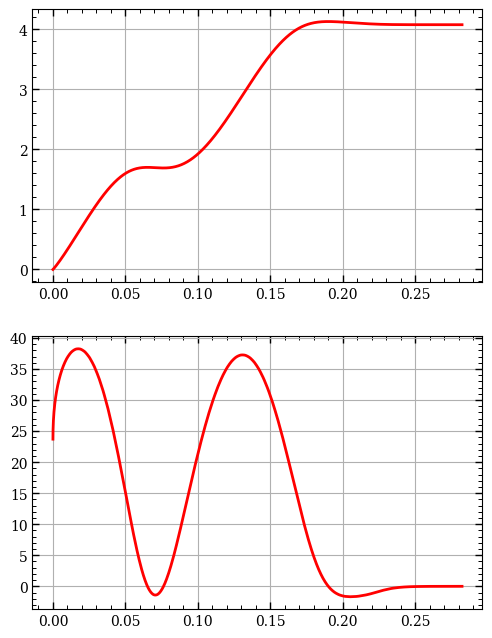

In [366]:
track = Tracking(beam, em3d, 1000e-12, 1e-12)
y0 = track.beam.dist[0,0:6]
#print y0
#print em3d.get_field(y0[0], y0[1], y0[2], 0)

import timeit
time1 = timeit.default_timer()
ref = track.ref(y0, 1000e-12, 10e-12)
time2 = timeit.default_timer()
print time2-time1

fig, [ax1, ax2] = plt.subplots(figsize = (6, 8), nrows = 2)
Ek = momentum2kinetic(ref[:,5]/1e6); print Ek[-1]
ax1.plot(ref[:,2], Ek, '-')
ax1.grid()

ax2.plot(ref[:,2], ref[:,9]/1e6, '-')
ax2.grid()

In [379]:
beam = Beam('beam180.ini')
track = Tracking(beam, em3d, 1000e-12, 10e-12)
print track.beam.dist
import timeit
time1 = timeit.default_timer()
ref = track.step(1)
time2 = timeit.default_timer()
print time2-time1

[[ 0.0000e+00  0.0000e+00  0.0000e+00 ... -1.0000e-06  1.0000e+00
   5.0000e+00]
 [ 6.2500e-05  0.0000e+00  5.0000e-04 ... -1.0000e-06  1.0000e+00
   3.0000e+00]
 [ 0.0000e+00  6.2500e-05 -5.0000e-04 ... -1.0000e-06  1.0000e+00
   3.0000e+00]
 ...
 [ 4.3226e-05  6.3007e-05  3.3280e-04 ... -1.0000e-06  1.0000e+00
   5.0000e+00]
 [ 1.1478e-05  9.6867e-05 -1.7553e-04 ... -1.0000e-06  1.0000e+00
   5.0000e+00]
 [-4.1042e-05  1.0727e-04 -7.3778e-04 ... -1.0000e-06  1.0000e+00
   5.0000e+00]]
1
iter =      1, time = 1.000000E-11
0.0102747000055


In [378]:
print momentum2kinetic(track.beam.dist[:,5]/1e6)

[4.07786389 4.07786389 4.07786389 4.07786389 4.07786389 4.07786389
 4.07786389 4.07722526 4.0773317  4.07743814 4.07754457 4.07765102
 4.07775745 4.07713403 4.07724047 4.07734691 4.07745334 4.07755979
 4.07766622 4.07777266 4.07714924 4.07725567 4.07736211 4.07746855
 4.07757499 4.07768143 4.07778787 4.07716444 4.07727088 4.07737732
 4.07748375 4.0775902  4.07769663 4.07780307 4.07717965 4.07728608
 4.07739252 4.07749896 4.0776054  4.07771184 4.07781828 4.07719485
 4.07730129 4.07740773 4.07751416 4.07762061 4.07772704 4.07783348
 4.07721006 4.07731649 4.07742293 4.07752937 4.07763581 4.07774225
 4.07784869 4.07712099 4.07722744 4.07733387 4.07744032 4.07754675
 4.07765319 4.07775963 4.0771362  4.07724264 4.07734908 4.07745552
 4.07756195 4.0776684  4.07777483 4.0771514  4.07725785 4.07736428
 4.07747073 4.07757716 4.0776836  4.07779004 4.07716661 4.07727305
 4.07737949 4.07748593 4.07759236 4.07769881 4.07780524 4.07718181
 4.07728826 4.07739469 4.07750113 4.07760757 4.07771401 4.0778

In [ ]:
NCOUNT = 0
num_cores = 1

import timeit

emsolver.add_external_field('LW', lw.EM3D)
emsolver.add_external_field('BW', bw.EM3D)

beam.load('beam.ini')

t0 = 0; dt = 10e-12; t1 = 2000e-12; dt_out = 50e-12
n_steps = int(t1/dt)

track = Tracking(t1, dt, t0, out_inteval = int(dt_out/dt))

Ek = 5000

n_stepped = 0
stime = 0
while n_stepped<n_steps:
    time1 = timeit.default_timer()
    track.step(1, num_cores)
    time2 = timeit.default_timer()
    stime = stime+(time2-time1)

    n_stepped += 1

    print '1 step takes: ', stime/n_stepped

    beam.post()
    if beam.stat[6] > Ek:
        track.dump()
        break
print 'Total time:', stime